### Keras implementation of day-ahead prediction of the ISO-NE hourly demand data (LSTM based)

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
df_master = pd.read_csv('dataset/selected_data_ISONE.csv',parse_dates=True,index_col='date')

In [3]:
df_master.head(24)

year  month  day  weekday  hour   demand  temperature
date                                                             
2003-03-01  2003      3    1        7     1  12863.0           23
2003-03-01  2003      3    1        7     2  12389.0           22
2003-03-01  2003      3    1        7     3  12155.0           21
2003-03-01  2003      3    1        7     4  12072.0           21
2003-03-01  2003      3    1        7     5  12160.0           22
2003-03-01  2003      3    1        7     6  12568.0           21
2003-03-01  2003      3    1        7     7  13236.0           22
2003-03-01  2003      3    1        7     8  14190.0           22
2003-03-01  2003      3    1        7     9  15213.0           24
2003-03-01  2003      3    1        7    10  15647.0           27
2003-03-01  2003      3    1        7    11  15653.0           30
2003-03-01  2003      3    1        7    12  15416.0           33
2003-03-01  2003      3    1        7    13  14994.0           35
2003-03-01  2003      3    1        7    14  14581.0           37
2003-03-01  2003      3    1        7    15  14335.0           37
2003-03-01  2003      3    1        7    16  14269.0           38
2003-03-01  2003      3    1        7    17  14685.0           37
2003-03-01  2003      3    1        7    18  15680.0           36
2003-03-01  2003      3    1        7    19  16386.0           35
2003-03-01  2003      3    1        7    20  16020.0           35
2003-03-01  2003      3    1        7    21  15476.0           34
2003-03-01  2003      3    1        7    22  14753.0           34
2003-03-01  2003      3    1        7    23  13757.0           33
2003-03-01  2003      3    1        7    24  12707.0           33

In [4]:
df_master.tail()

year  month  day  weekday  hour   demand  temperature
date                                                             
2014-12-31  2014     12   31        4    20  16955.0           22
2014-12-31  2014     12   31        4    21  16243.0           21
2014-12-31  2014     12   31        4    22  15525.0           21
2014-12-31  2014     12   31        4    23  14759.0           18
2014-12-31  2014     12   31        4    24  14071.0           19

So, the dataset timestamp starts from March 01, 2003 and ends at December 31, 2014.

In [5]:
def plot_daily_demand(df,y):
    '''
    It returns the daily load demand vs hour for a specific year.
    
    df = dataframe
    y = year
    
    '''
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    dfx = df.loc[df.year==y]

    for i,m in enumerate(set(dfx.month)):
        if m in set(dfx.month):
            dfxx = dfx.loc[dfx.month==m]
            #print(monthDict[m],end=' ')
            for d in range(1,31):
                if d in set(dfxx.day):
                    #print(d)
                    dfxxx = dfxx.loc[dfxx.day==d]
                    ttl = str('Year: '+str(y)+' Month: '+str(monthDict[m])+' '+str(d))
                    plt.figure(ttl)
                    plt.plot(dfxxx.hour,dfxxx.demand)
                    #print(dfxxx)
                    plt.title(ttl)

In [6]:
#plot_daily_demand(df_master,2003)

### Input Format
X = (M,D,W,H,T)
<br>
Y = demand
<br>
- M = month = 1 to 12
- D = day = 1 to 31
- W = week = 1 to 4
- H = hour = 1 to 24
- T = temp



In [28]:
df_master.shape

(103776, 7)

In [29]:
# daily max load value
D_max_daily = df_master.groupby('date').demand.max().get_values()

In [30]:
#normalizing load value
D_max = max(D_max_daily)
df = df_master.demand/D_max

In [31]:
Y = np.array(df)

In [32]:
df_master.head()

year  month  day  weekday  hour   demand  temperature
date                                                             
2003-03-01  2003      3    1        7     1  12863.0           23
2003-03-01  2003      3    1        7     2  12389.0           22
2003-03-01  2003      3    1        7     3  12155.0           21
2003-03-01  2003      3    1        7     4  12072.0           21
2003-03-01  2003      3    1        7     5  12160.0           22

In [33]:
X = df_master[['month','day','weekday','hour','temperature']]

In [34]:
X = X.values



### Adding Features

In [35]:
# add season and festival info to the dataset
import datetime
iter_date = datetime.date(2003, 3, 1)
season = np.zeros((24*4324,))
festival = np.zeros((24*4324,))
for i in range(4324):
    month = iter_date.month
    day = iter_date.day
    for j in range(24):
        if (month==4) | (month==5) | ((month==3) and (day>7)) | ((month==6) and (day<8)):
            season[i*24 + j] = 0 #spring
        elif (month==7) | (month==8) | ((month==6) and (day>7)) | ((month==9) and (day<8)):
            season[i*24 + j] = 1 #summer
        elif (month==10) | (month==11) | ((month==9) and (day>7)) | ((month==12) and (day<8)):
            season[i*24 + j] = 2 #autumn
        elif (month==1) | (month==2) | ((month==12) and (day>7)) | ((month==3) and (day<8)):
            season[i*24 + j] = 3 #winter

        if (month == 7) and (day == 4):
            festival[i*24 + j] = 1
        if (month == 11) and (iter_date.weekday() == 4) and (day + 7 > 30):
            festival[i*24 + j] = 1
        if (month == 12) and (day == 25):
            festival[i*24 + j] = 1
    iter_date = iter_date + datetime.timedelta(1)

In [36]:
season = np.reshape(season,(season.shape[0],1))
X_data = np.append(X,season,axis=1)

In [37]:
X = np.reshape(X_data,(X_data.shape[0],1,X_data.shape[1]))

In [38]:
X.shape

(103776, 1, 6)

### Splitting the dataset

In [39]:
# Split the training dataset in 80% / 20%
from sklearn.model_selection import train_test_split

#dataset splitted into train,val,test as 64%,16%,20%
X_train,X_test,Y_train,Y_test = train_test_split( X,Y,test_size=0.2, random_state=42)
X_train,X_val,Y_train,Y_val = train_test_split( X_train,Y_train,test_size=0.2, random_state=42)

In [40]:
X_test.shape

(20756, 1, 6)

In [41]:
X_train.shape

(66416, 1, 6)

### Defining Model

In [42]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

from keras.layers import TimeDistributed

Using TensorFlow backend.


In [66]:
#lstm-lstm-dense-dense model
model = Sequential()
model.add(LSTM(20, input_shape=(1,6),init= 'uniform', return_sequences=True)) #input shape (1,5) to (1,6)
model.add(LSTM(20,init= 'uniform', activation='selu'))
model.add(Dense(10,init= 'uniform', activation='selu'))
model.add(Dense(10,init= 'uniform', activation='selu'))
model.add(Dense(1,init= 'uniform', activation='linear'))

model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['acc'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, input_shape=(1, 6), return_sequences=True, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, activation="selu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="selu", kernel_initializer="uniform")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="selu", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` 

In [67]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 20)             2160      
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 5,771
Trainable params: 5,771
Non-trainable params: 0
_________________________________________________________________


### Training and Testing 

In [68]:
start_time = time.time()
history = model.fit(X_train, Y_train, nb_epoch=100, shuffle=True, batch_size=32,validation_data=(X_val,Y_val))
finish_time = time.time()
print("--- %s seconds ---" % (finish_time - start_time))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 66416 samples, validate on 16604 samples
Epoch 1/100
66416/66416 [==============================] - 11s 165us/step - loss: 11.8011 - acc: 1.5057e-05 - val_loss: 8.4801 - val_acc: 0.0000e+00
Epoch 2/100
66416/66416 [==============================] - 11s 164us/step - loss: 7.7956 - acc: 1.5057e-05 - val_loss: 6.8148 - val_acc: 0.0000e+00
Epoch 3/100
66416/66416 [==============================] - 11s 159us/step - loss: 6.8388 - acc: 1.5057e-05 - val_loss: 6.3854 - val_acc: 0.0000e+00
Epoch 4/100
66416/66416 [==============================] - 9s 136us/step - loss: 6.2891 - acc: 1.5057e-05 - val_loss: 6.1513 - val_acc: 0.0000e+00
Epoch 5/100
66416/66416 [==============================] - 10s 154us/step - loss: 5.7988 - acc: 1.5057e-05 - val_loss: 5.1974 - val_acc: 0.0000e+00
Epoch 6/100
66416/66416 [==============================] - 9s 142us/step - loss: 5.4149 - acc: 1.5057e-05 - val_loss: 5.4947 - val_acc: 0.0000e+00
Epoch 7/100
66416/66416 [==============================] - 10s 

Epoch 56/100
66416/66416 [==============================] - 10s 148us/step - loss: 3.5119 - acc: 1.5057e-05 - val_loss: 3.3301 - val_acc: 0.0000e+00
Epoch 57/100
66416/66416 [==============================] - 9s 130us/step - loss: 3.5061 - acc: 1.5057e-05 - val_loss: 3.6366 - val_acc: 0.0000e+00
Epoch 58/100
66416/66416 [==============================] - 8s 122us/step - loss: 3.5063 - acc: 1.5057e-05 - val_loss: 3.3860 - val_acc: 0.0000e+00
Epoch 59/100
66416/66416 [==============================] - 8s 120us/step - loss: 3.4939 - acc: 1.5057e-05 - val_loss: 3.6351 - val_acc: 0.0000e+00
Epoch 60/100
66416/66416 [==============================] - 8s 120us/step - loss: 3.4944 - acc: 1.5057e-05 - val_loss: 3.3097 - val_acc: 0.0000e+00
Epoch 61/100
66416/66416 [==============================] - 8s 117us/step - loss: 3.4879 - acc: 1.5057e-05 - val_loss: 3.6864 - val_acc: 0.0000e+00
Epoch 62/100
66416/66416 [==============================] - 8s 124us/step - loss: 3.4732 - acc: 1.5057e-05 - va

In [70]:
print((finish_time - start_time)/60,'minutes')

15.119907526175181 minutes


#### 4 layer ANN
* For 30 epochs loss = 3.6846 [ReLU]
* For 30 epochs loss = 3.9690 [SeLU] 
* For 100 epochs loss = 3.6864 [SeLU] 
<br>
#### LSTM
* For 30 epochs loss = 3.9309 [SeLU]
* For 100 epochs loss = 3.4434 [SeLU] TEST MAPE : 3.6344 **This is significant improve. Next target is to add extra feature** 
<br>
**ADDED FEATURE**
*season*
* For 30 epochs loss = 3.7397 [SeLU] TEST MAPE : 3.7267
* For 100 epochs loss = 3.4244  [SeLU] TEST MAPE : 3.4859 **ANOTHER CHECKPOINT**
<br>
**DATASET SPLITTED [test,val,train]** [64,16,20]% <br>
**batch size from 10 to 32**
* For 30 epochs loss = 4.1719 [SeLU] TEST MAPE : 4.0555
* For 100 epochs loss = 3.3448 [SeLU] TEST MAPE : 3.3108 | 10.3528 minutes **ANOTHER CHECKPOINT**
* For 600 epochs loss = 3.0471 [SeLU] TEST MAPE : 3.0574 | 65.6526 minutes **VANISHING GRADIENT** after 300 epochs
#### Stateful LSTM
**batch size 28**
* For 30 epochs loss = 3.8349 [SeLU] TEST MAPE : N/A | 3.6711 minutes

#### Modified LSTM [lstm-lstm-dense-dense model]
**batch size 32**
* For 30 epochs loss = 3.7549 [SeLU] TEST MAPE : 3.5419 | 5.9089 minutes
* For 100 epochs loss = 3.3520 [ReLU] TEST MAPE : 3.2932 | 18.7115 minutes

#### Modified LSTM [lstm-lstm-dense-lstm-dense model]
**batch size 32**
* For 30 epochs loss = 3.9934 [ReLU] TEST MAPE : 3.9428 | 4.9078 minutes 
* For 30 epochs loss = 3.6778 [SeLU] TEST MAPE : 3.7730 | 6.1962 minutes
* For 100 epochs loss = 3.3075 [SeLU] TEST MAPE : 3.3141 | 19.0444 minutes **ANOTHER CHECKPOINT**
#### Modified LSTM Reduced Nurons [lstm-lstm-dense-lstm-dense model]
* For 30 epochs loss = 4.5118 [SeLU] TEST MAPE : 4.4422 | 4.3351 minutes 
* For 100 epochs loss = 3.5593 [**eLU**] TEST MAPE : 3.5601 | 13.4141 minutes

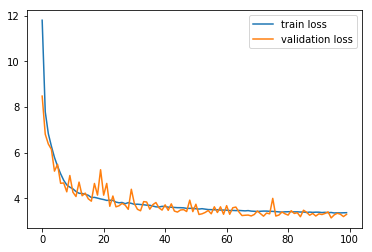

In [71]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot([i for i in range(len(loss))],loss)
plt.plot([i for i in range(len(val_loss))],val_loss)
plt.legend(['train loss','validation loss'])

# loss = history.history['loss']
# val_loss = history.history['val_loss']
# plt.plot([i for i in range(300)],loss[0:300])
# plt.plot([i for i in range(300)],val_loss[0:300])
# plt.legend(['train loss','validation loss'])

In [94]:
history.history

{'val_loss': [8.480136201629234,
  6.81475622204234,
  6.385409997302749,
  6.15132006769495,
  5.197381324005311,
  5.494717827247614,
  4.663906478215574,
  4.680328149618628,
  4.292317716336141,
  5.005596643526909,
  4.273684975038922,
  4.086897424145567,
  4.717024318053618,
  4.119379839303263,
  4.235102967967817,
  3.98704267266112,
  3.882165261102969,
  4.657800052402049,
  4.1484552200545295,
  5.25854203776261,
  4.145730561906818,
  4.660006063296346,
  3.658491796655731,
  4.108561119267062,
  3.634566101445488,
  3.681719612311352,
  3.7858156195837918,
  3.709451987237363,
  3.526083460775406,
  4.404021069561823,
  3.7731535416343247,
  3.5263970090635883,
  3.4626174708844037,
  3.8635532097252443,
  3.845855881523954,
  3.5318029539695965,
  3.7295799744155027,
  3.823700172991329,
  3.5918708362225535,
  3.4926707942754036,
  3.7223194222713314,
  3.482684436805907,
  3.765121086624208,
  3.4502249679000254,
  3.4051586254853223,
  3.496470522691014,
  3.513111699

In [72]:
scores = model.evaluate(X_test, Y_test)
print("TEST MAPE :",scores[0])

20756/20756 [==============================] - 1s 44us/step
TEST MAPE : 3.346658161183179


In [73]:
scores

[3.346658161183179, 0.0]

In [61]:
# test_y = []
# for i in range(24):
#     test = np.array([3,1,1,i,t[i]])
#     test = test.reshape(1,5)
#     y = model.predict(test)
#     test_y.append(y[0][0]*D_max)

In [59]:
test_y = []
for i in range(24,48):
    test = X[i]
    test = test.reshape(1,1,6)
    y = model.predict(test)
    test_y.append(y[0][0]*D_max)

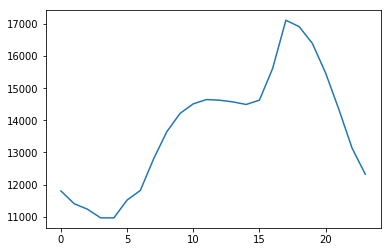

In [60]:
plt.plot([i for i in range(24)],test_y)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


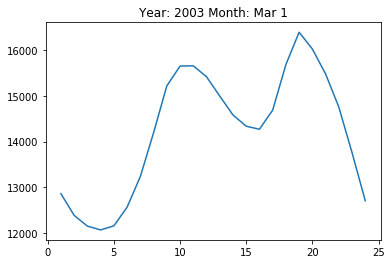

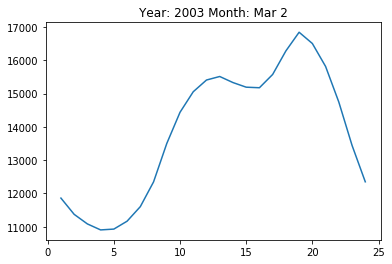

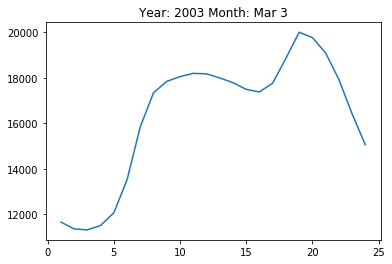

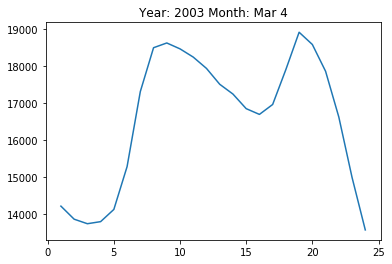

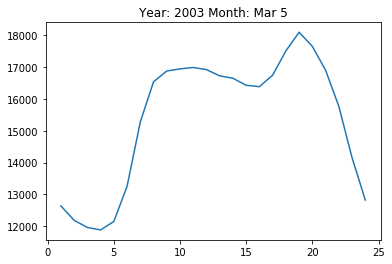

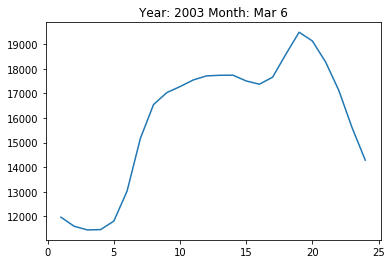

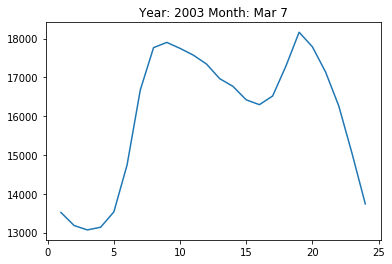

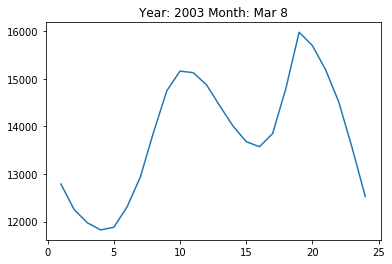

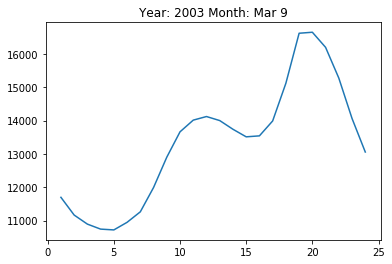

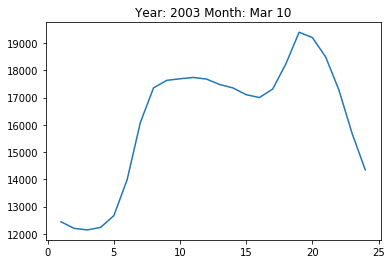

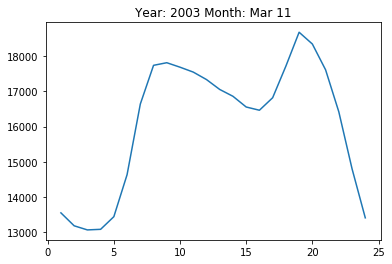

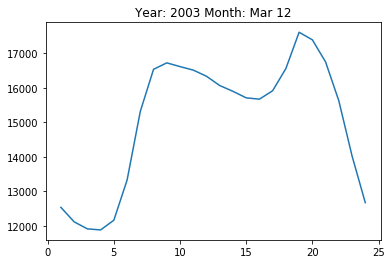

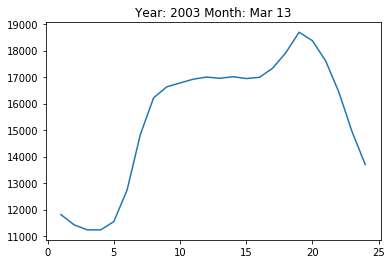

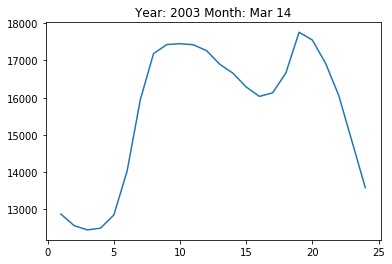

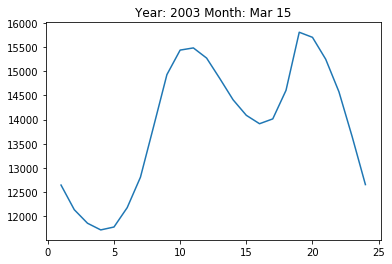

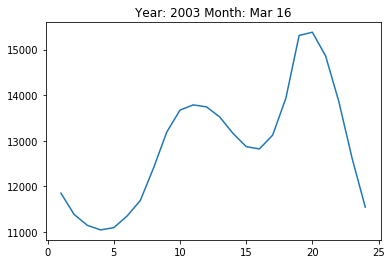

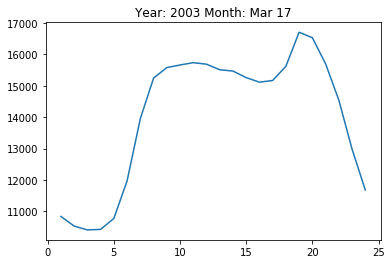

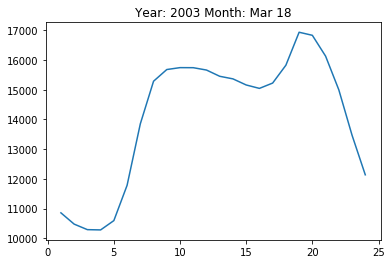

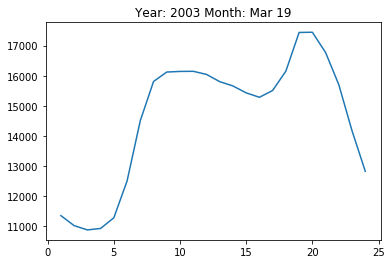

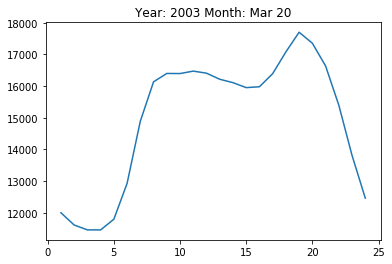

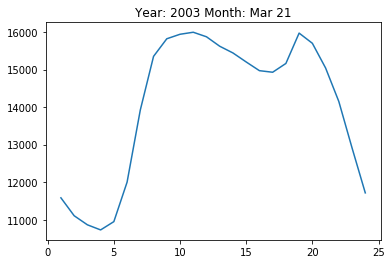

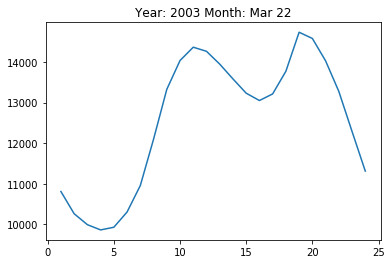

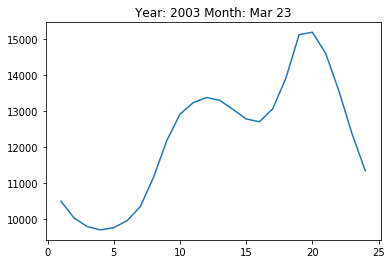

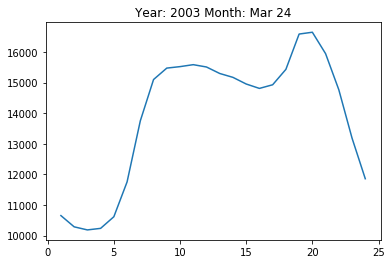

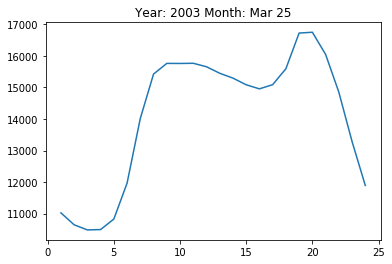

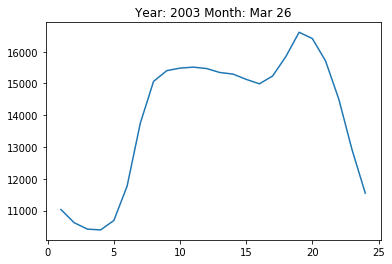

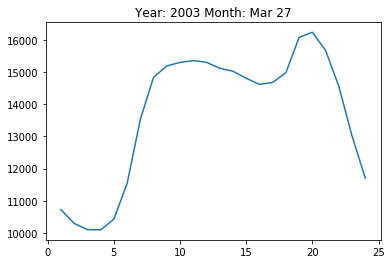

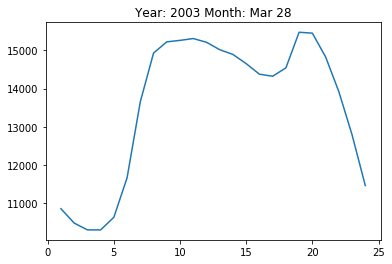

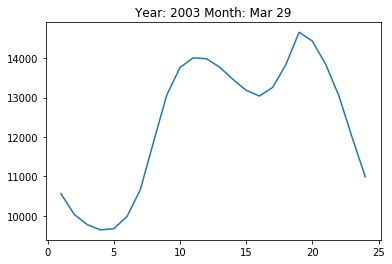

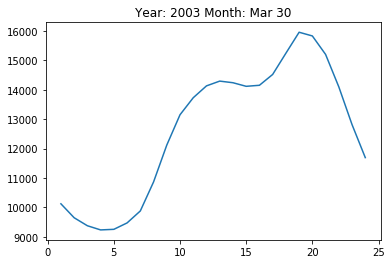

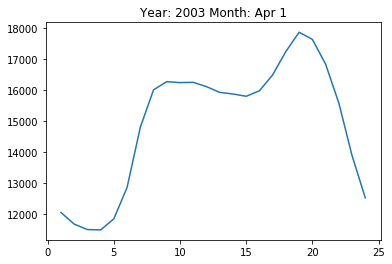

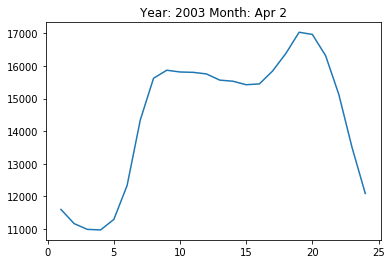

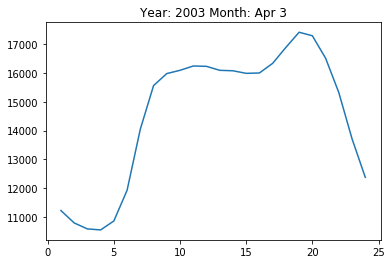

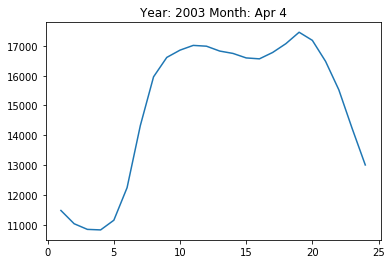

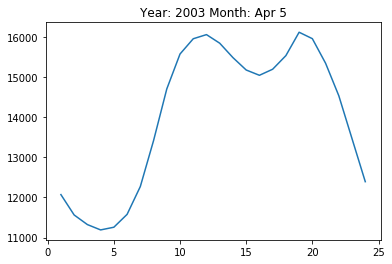

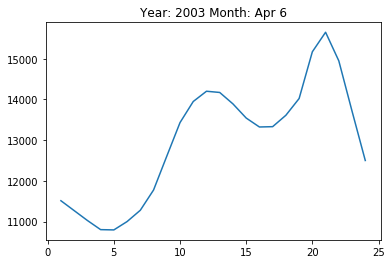

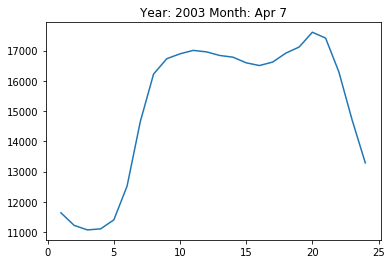

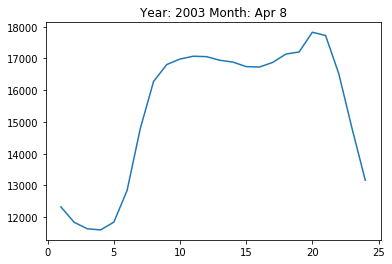

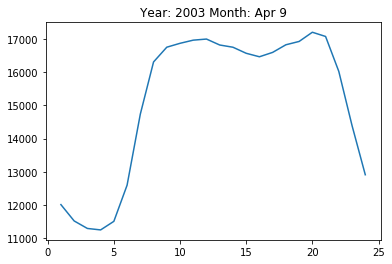

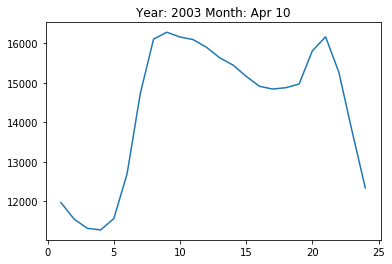

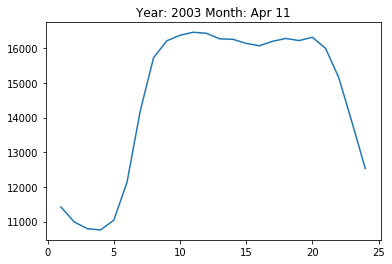

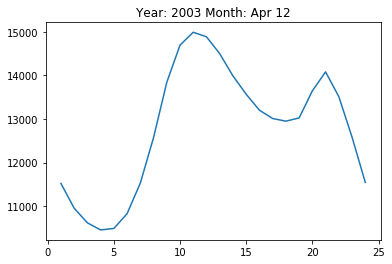

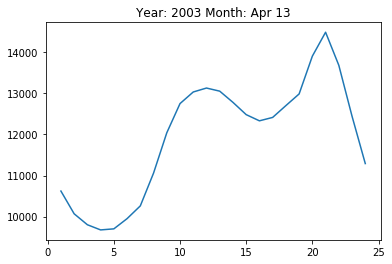

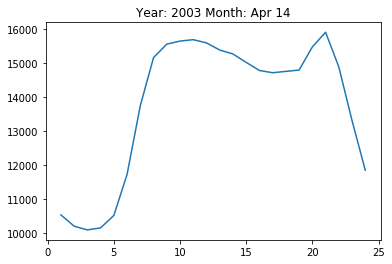

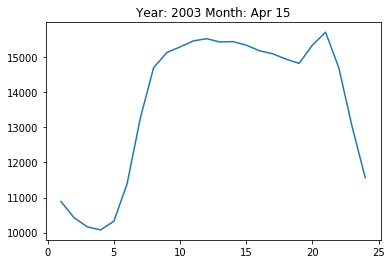

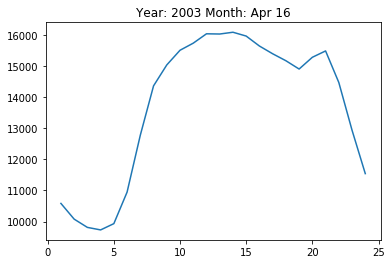

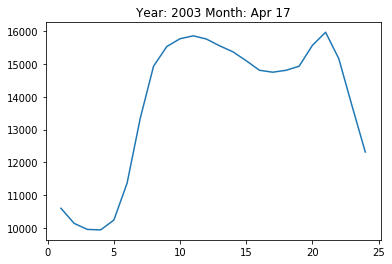

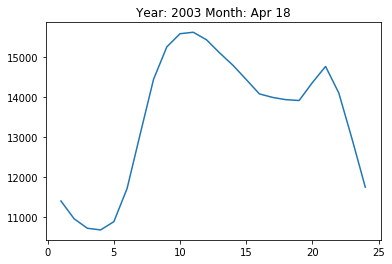

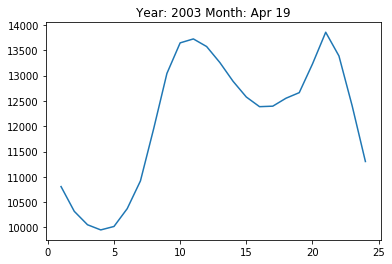

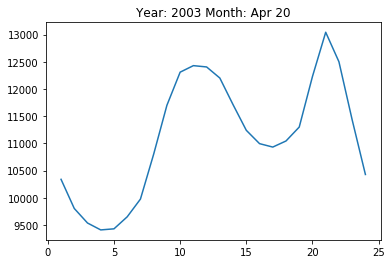

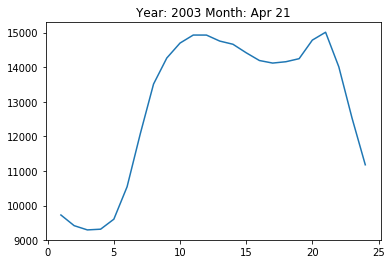

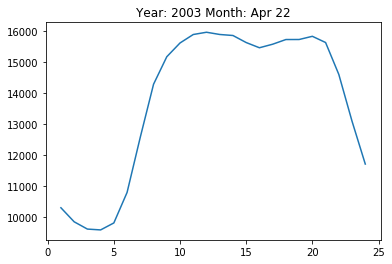

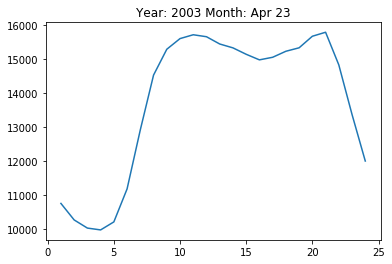

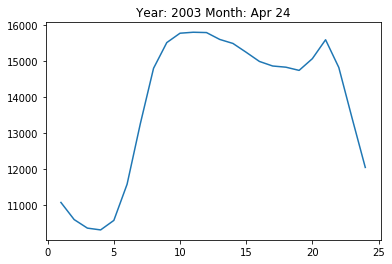

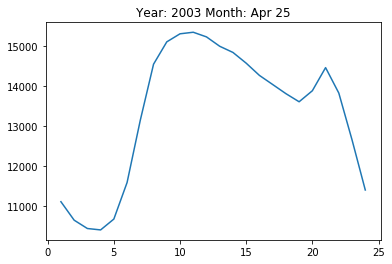

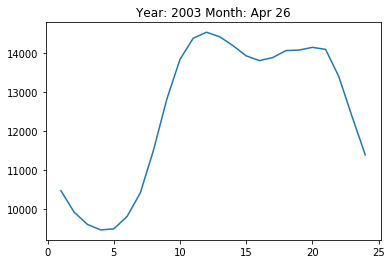

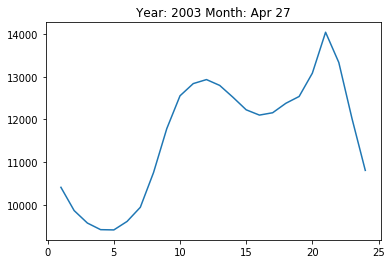

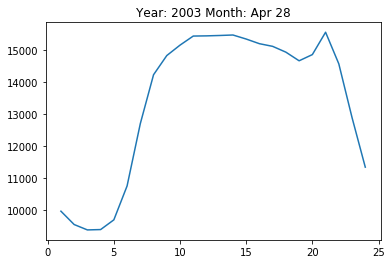

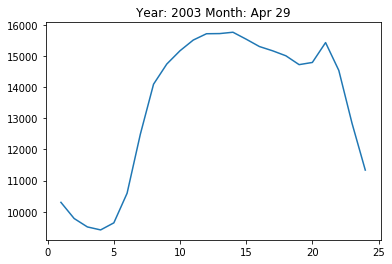

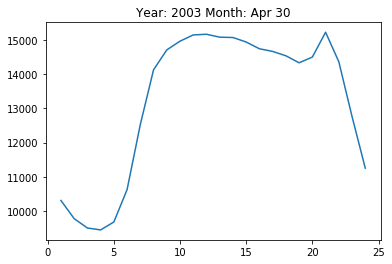

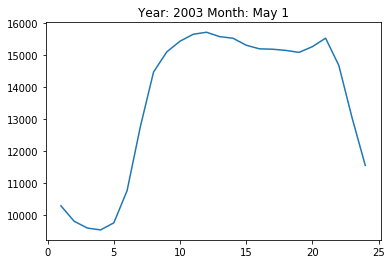

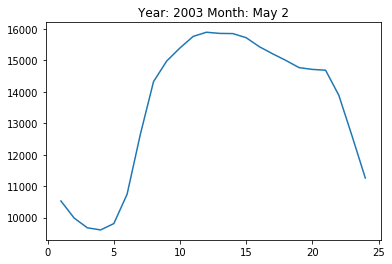

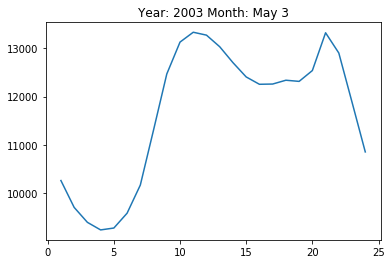

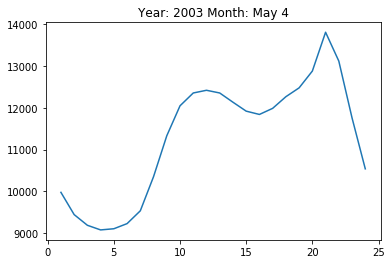

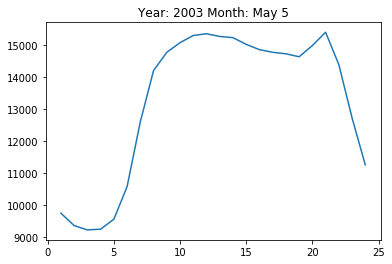

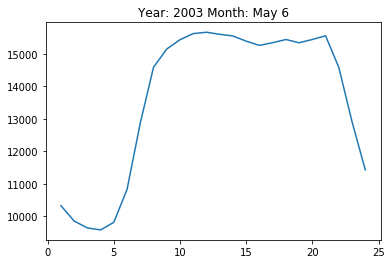

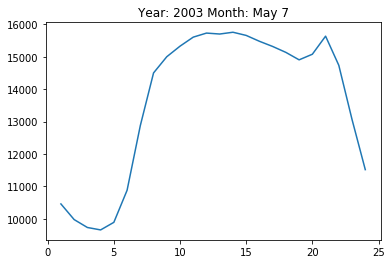

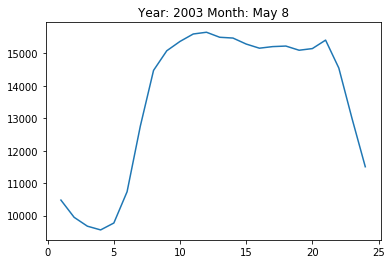

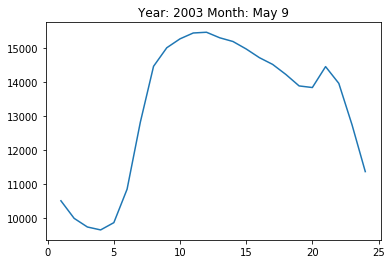

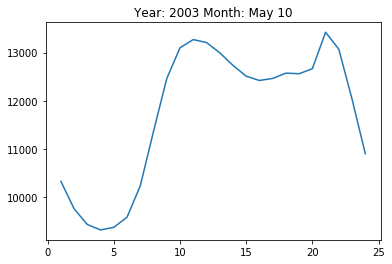

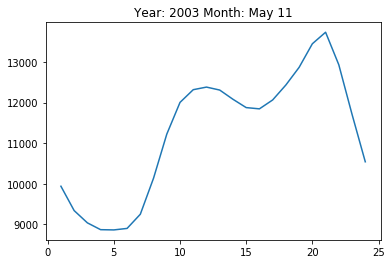

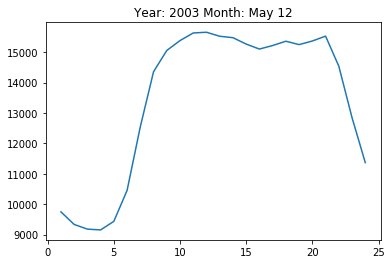

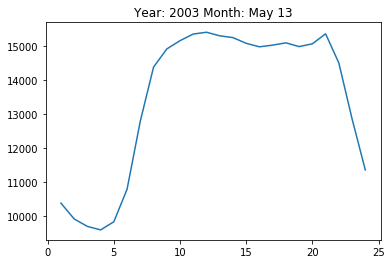

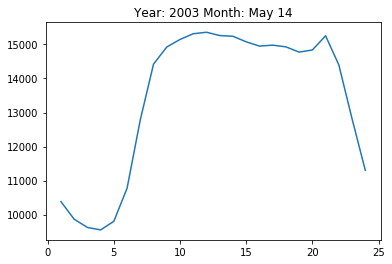

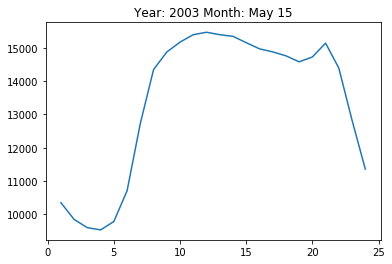

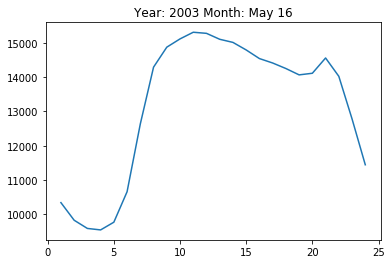

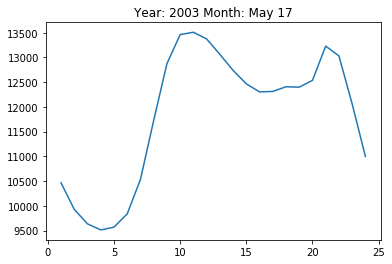

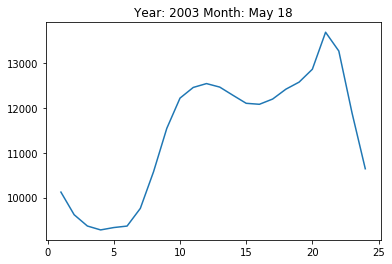

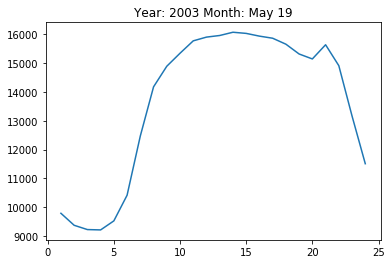

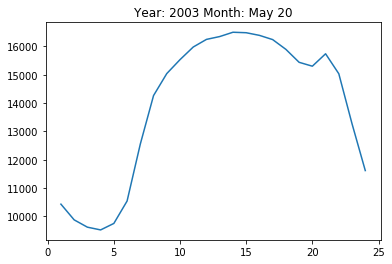

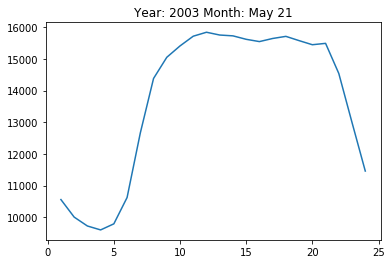

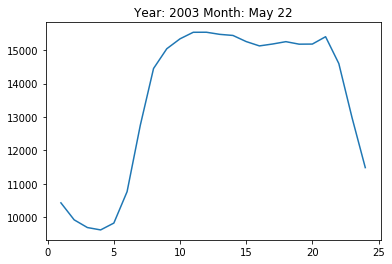

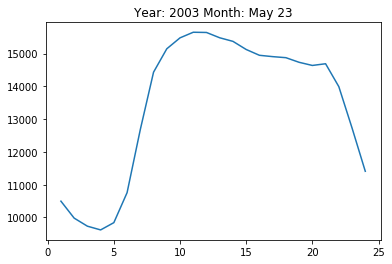

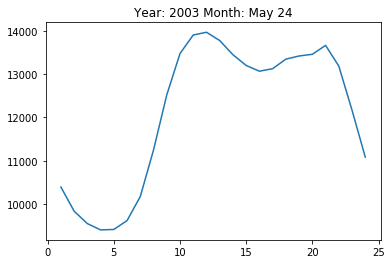

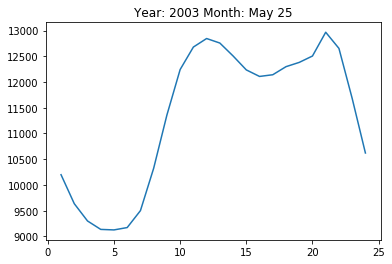

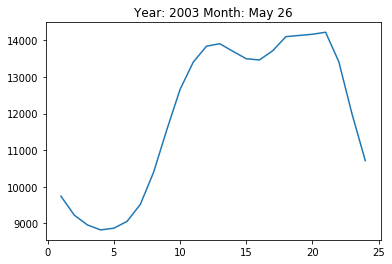

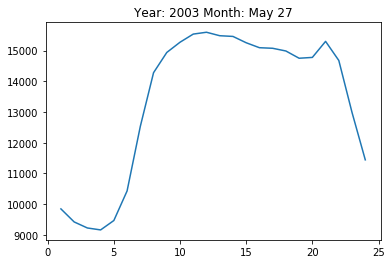

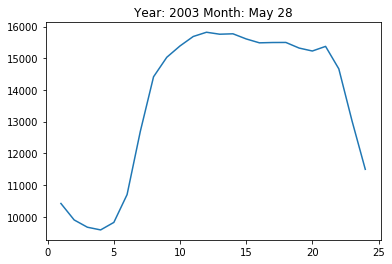

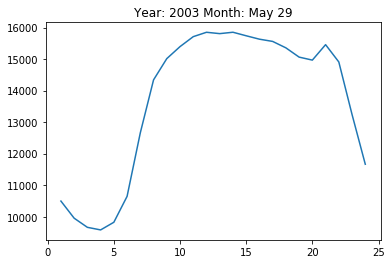

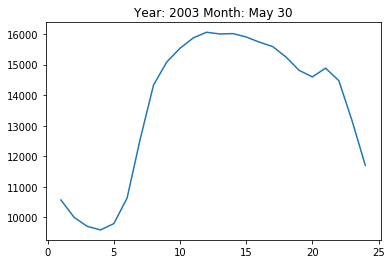

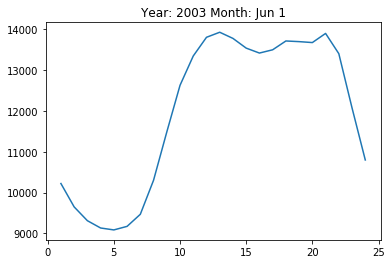

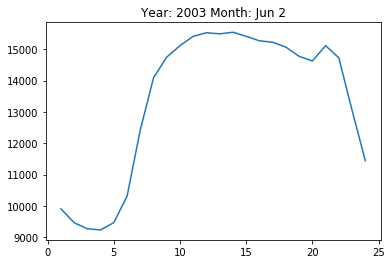

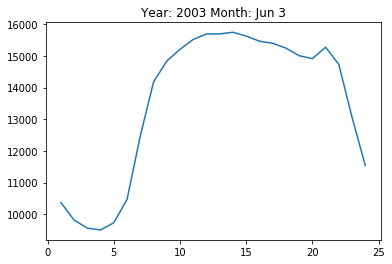

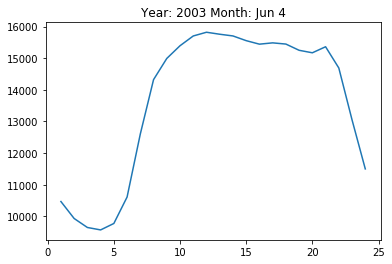

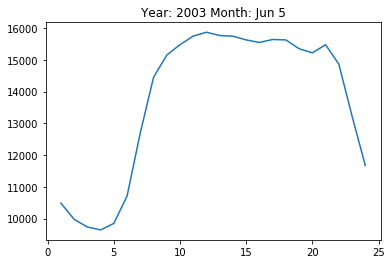

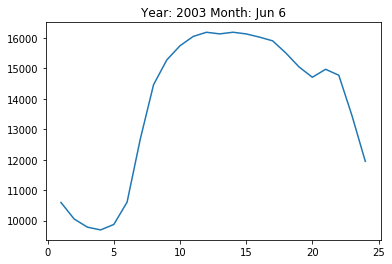

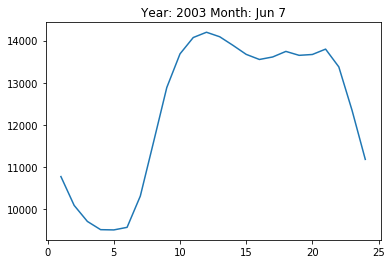

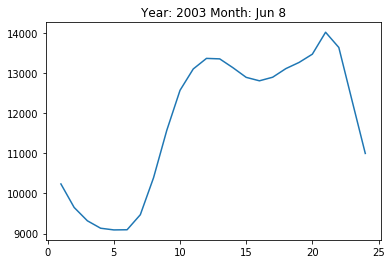

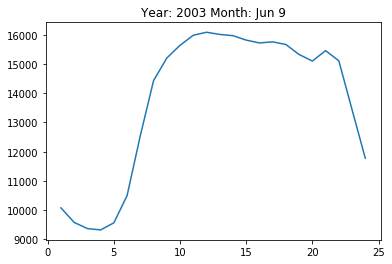

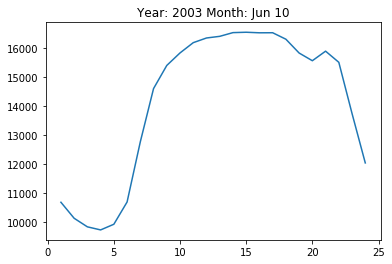

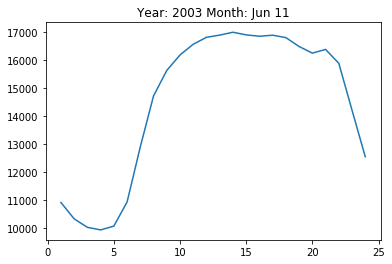

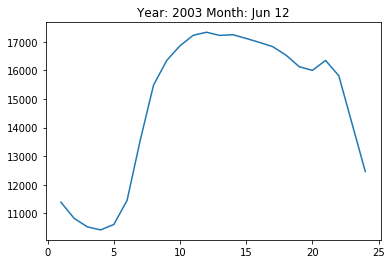

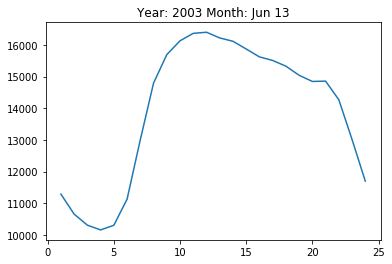

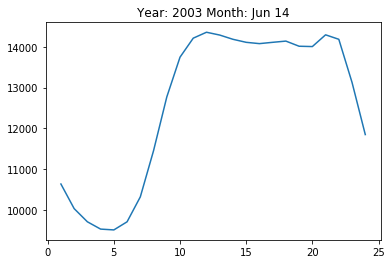

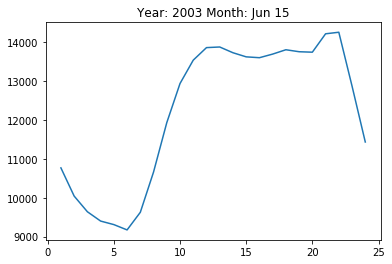

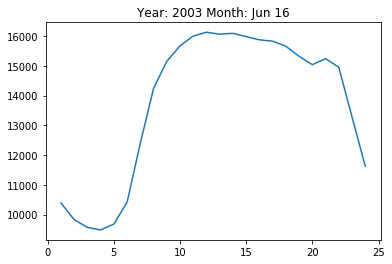

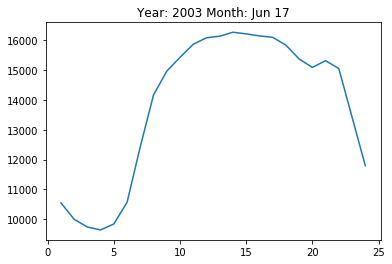

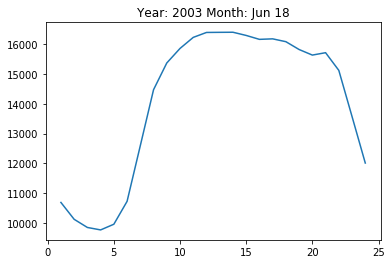

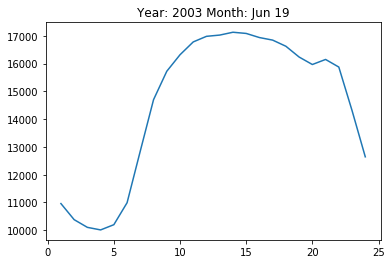

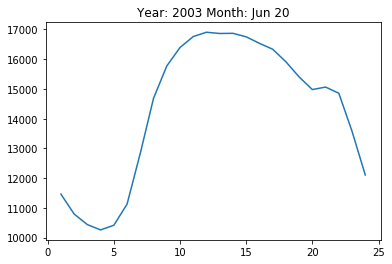

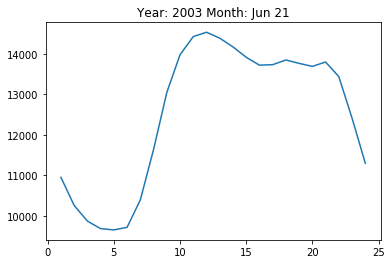

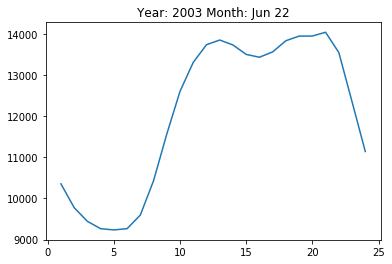

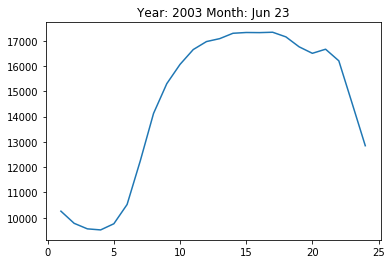

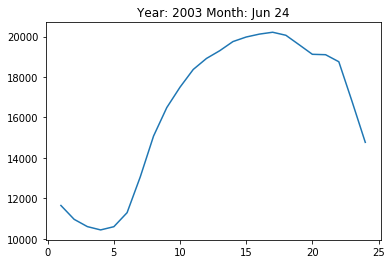

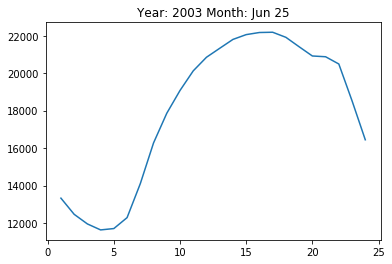

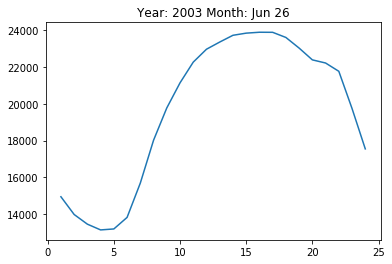

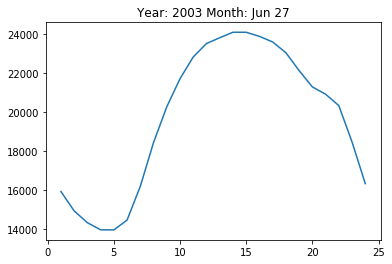

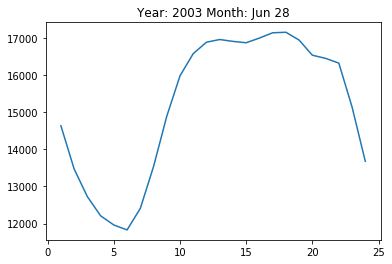

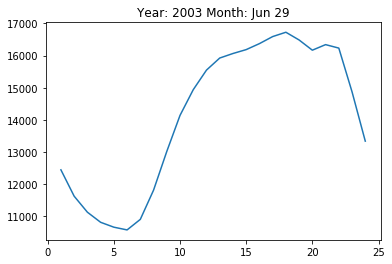

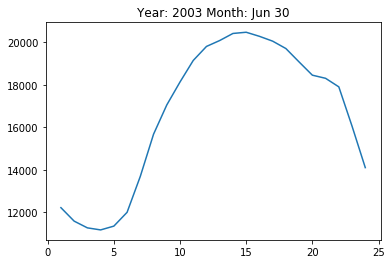

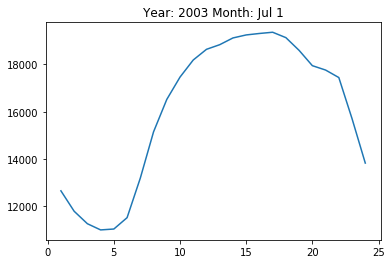

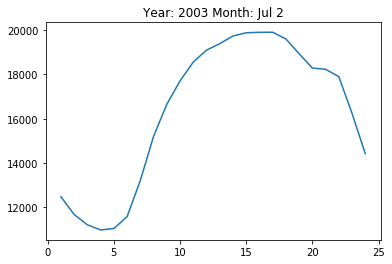

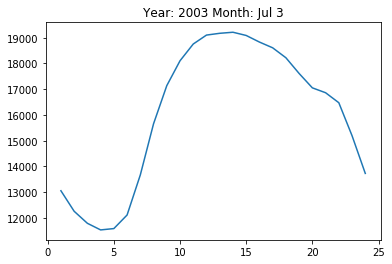

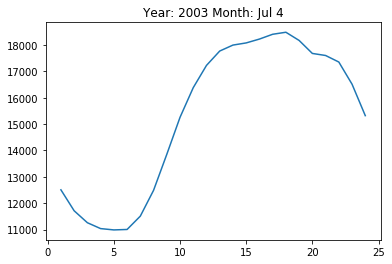

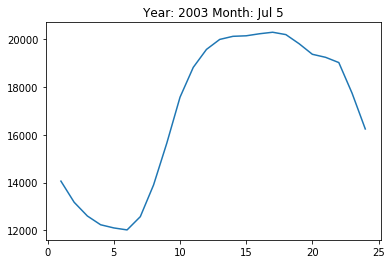

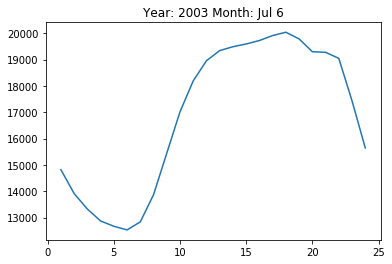

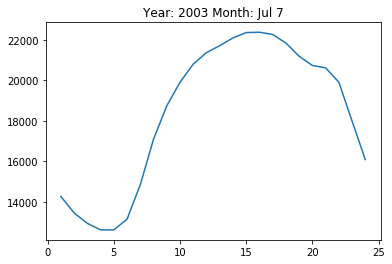

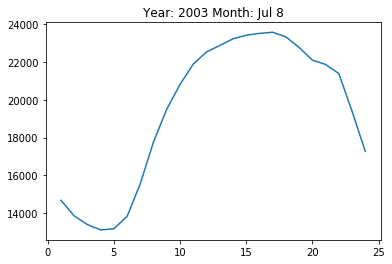

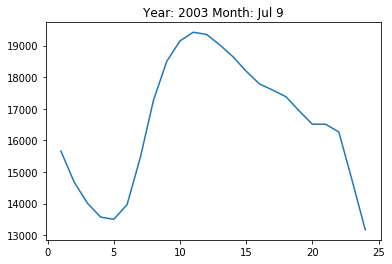

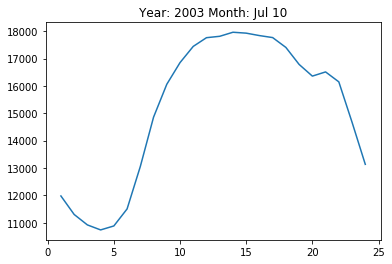

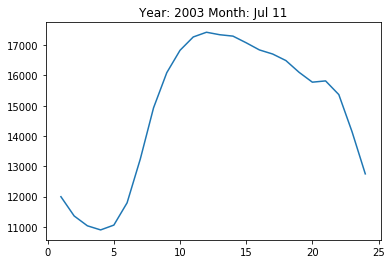

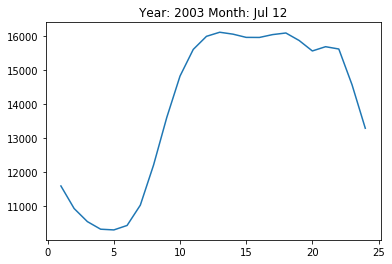

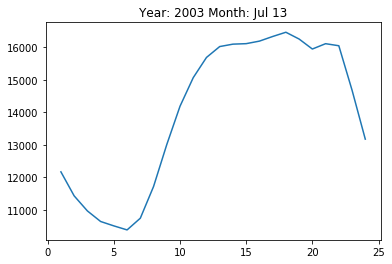

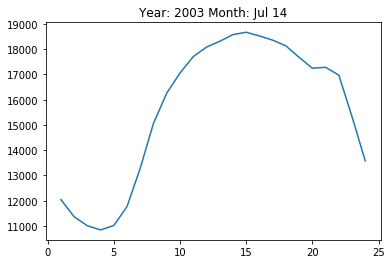

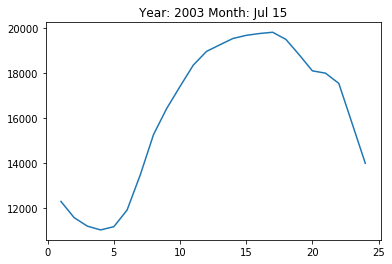

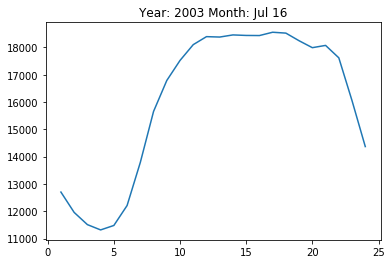

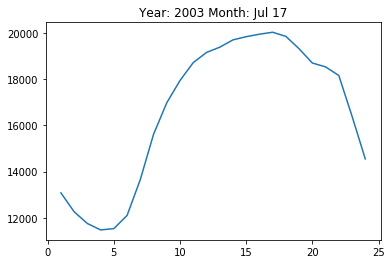

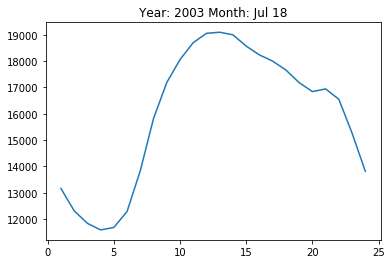

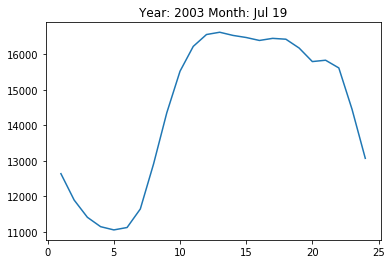

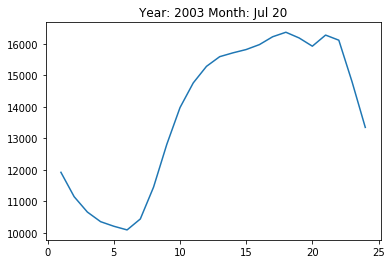

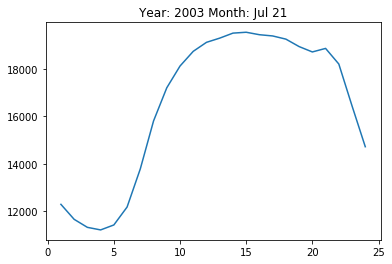

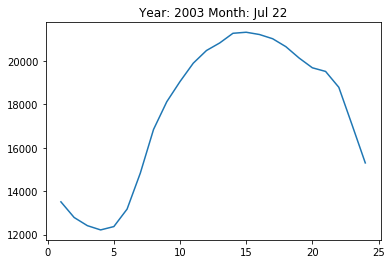

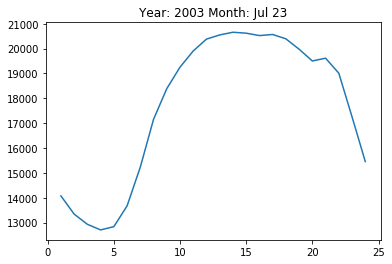

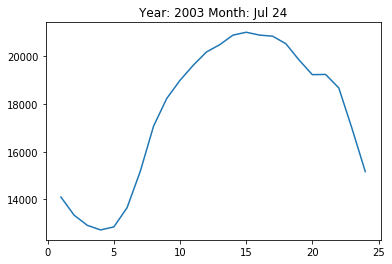

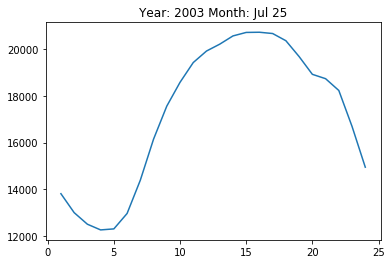

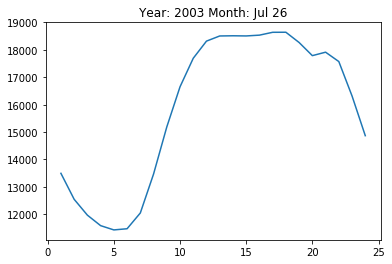

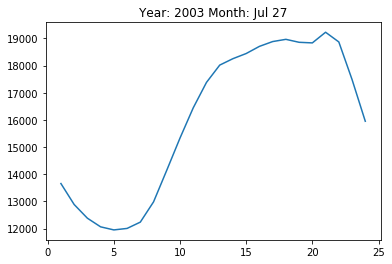

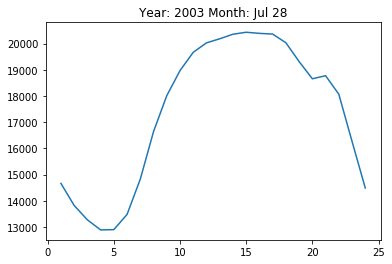

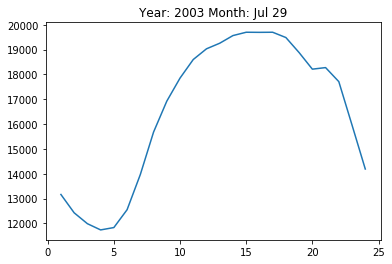

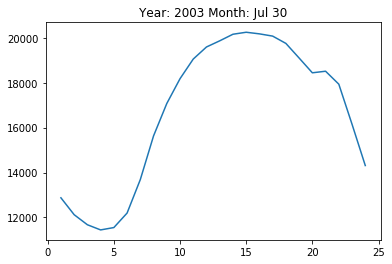

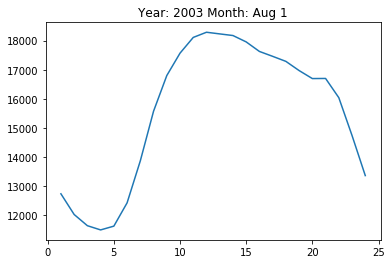

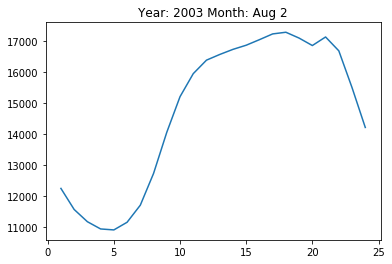

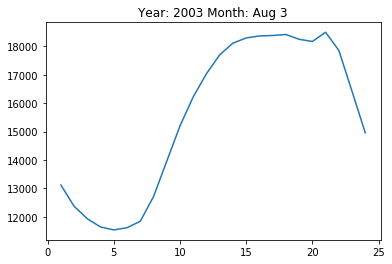

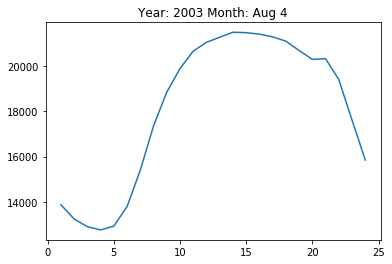

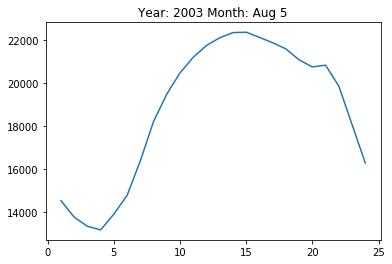

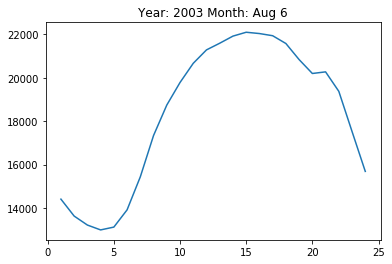

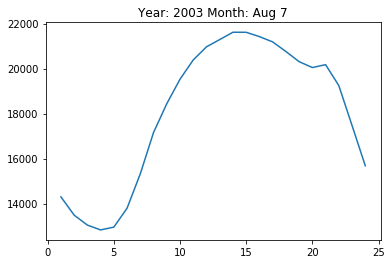

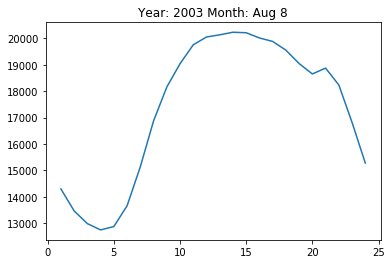

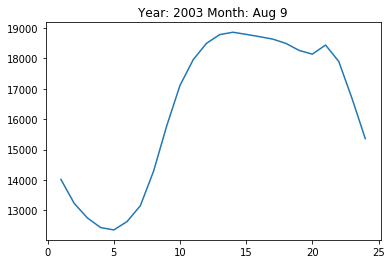

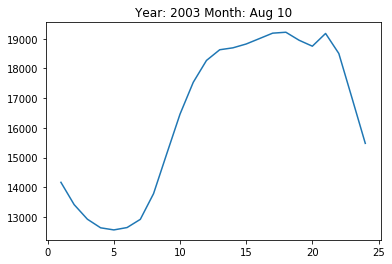

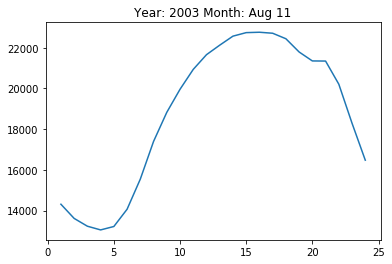

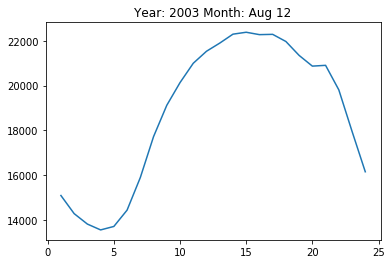

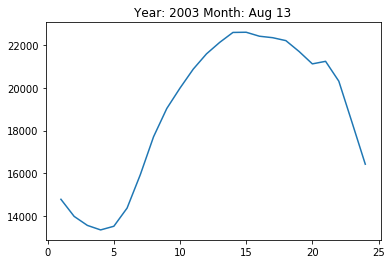

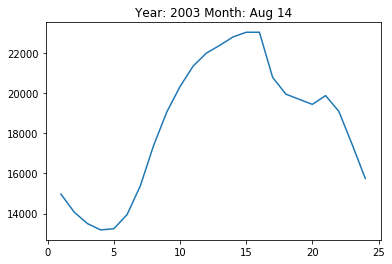

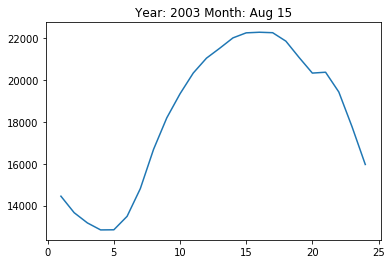

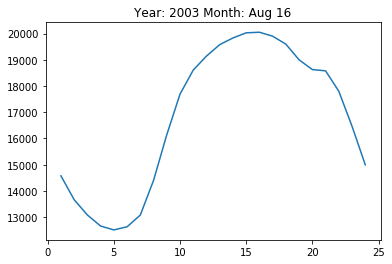

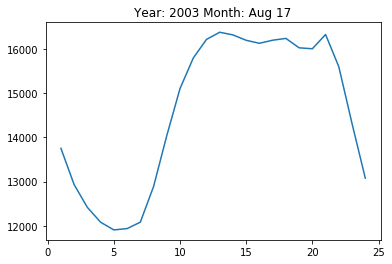

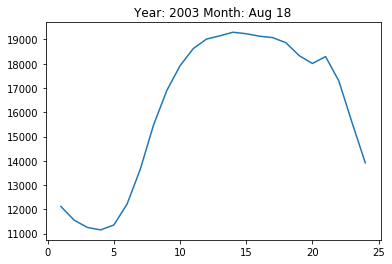

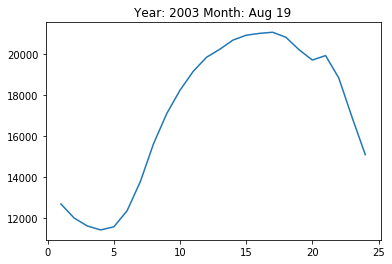

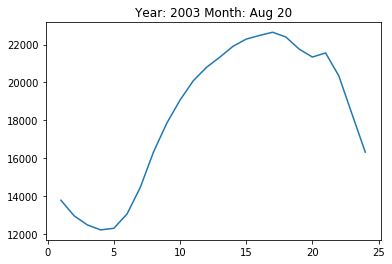

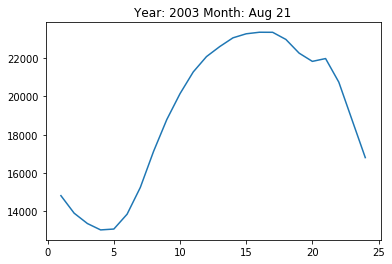

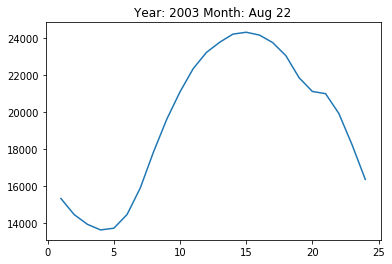

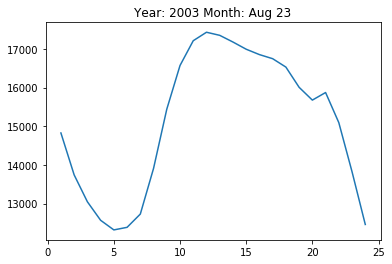

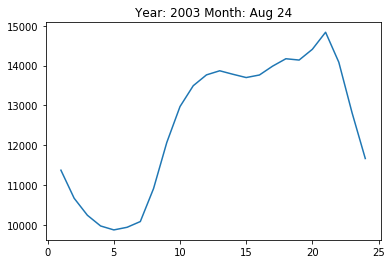

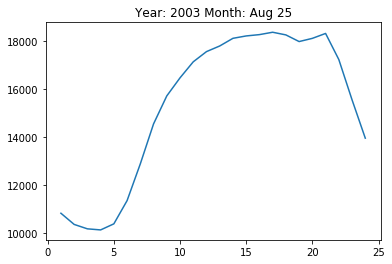

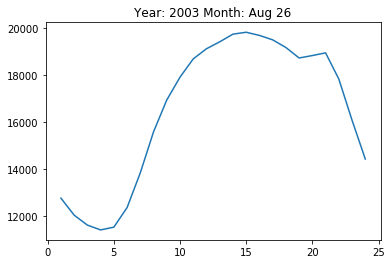

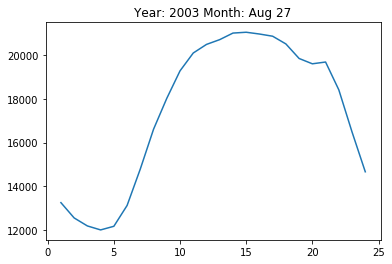

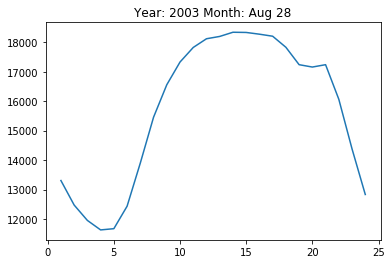

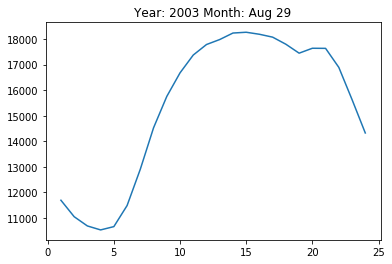

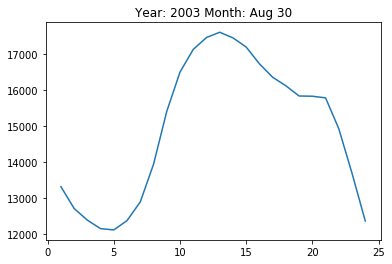

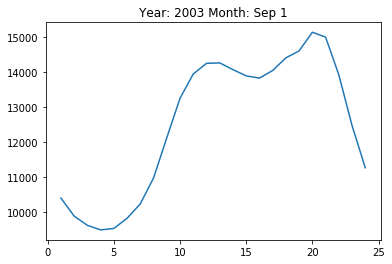

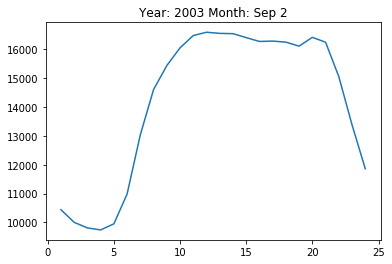

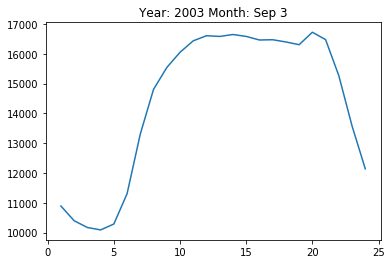

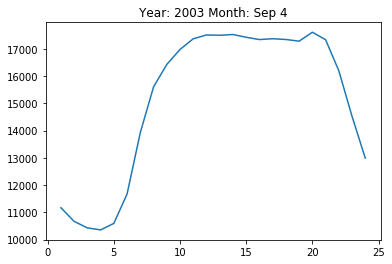

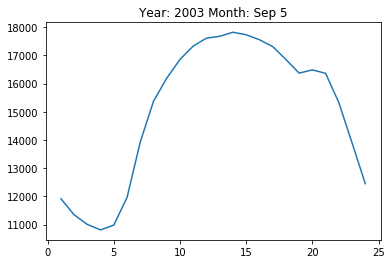

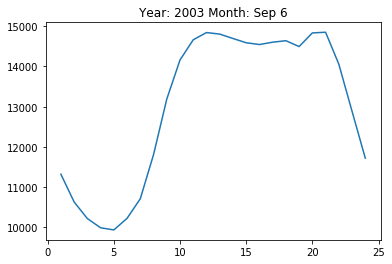

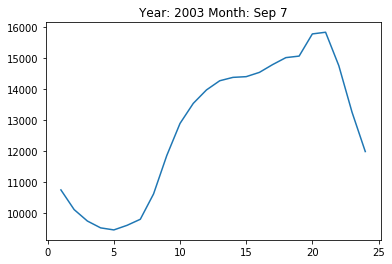

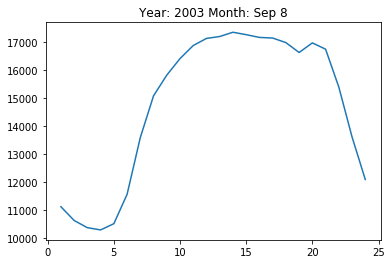

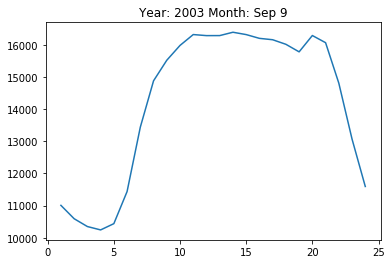

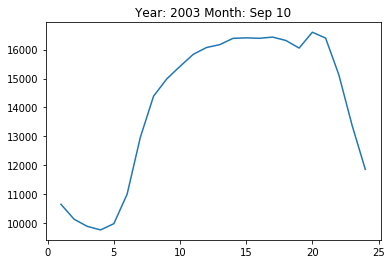

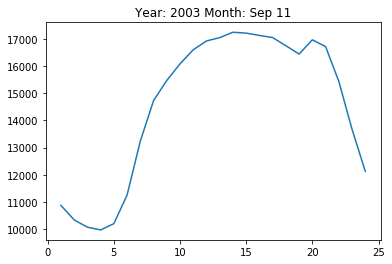

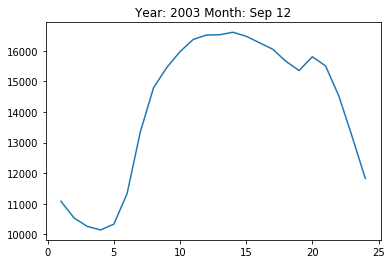

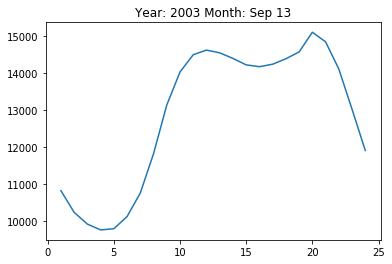

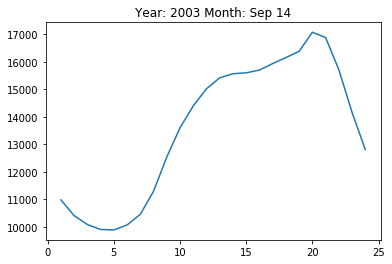

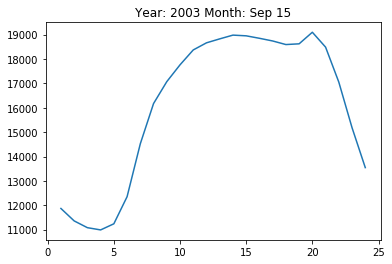

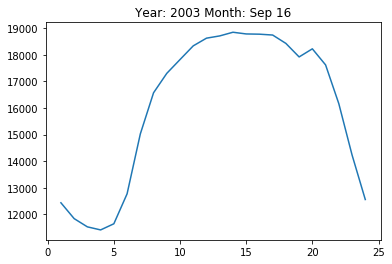

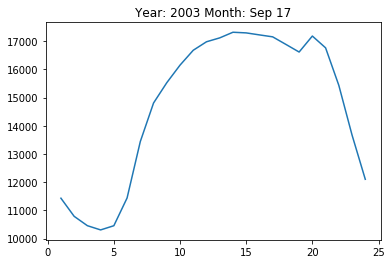

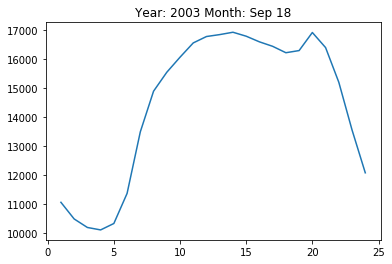

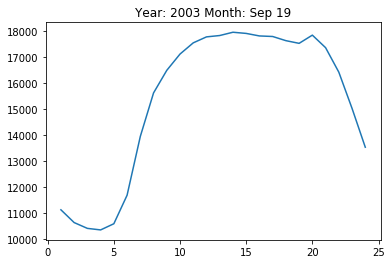

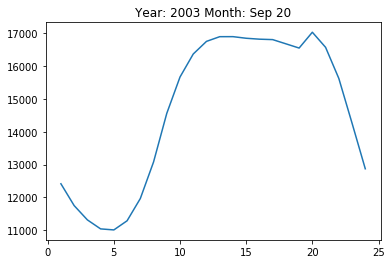

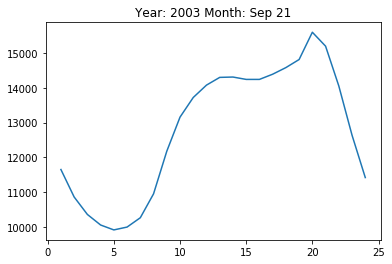

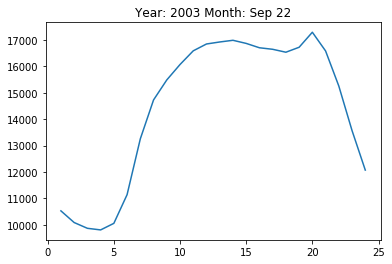

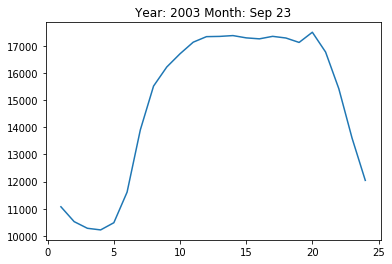

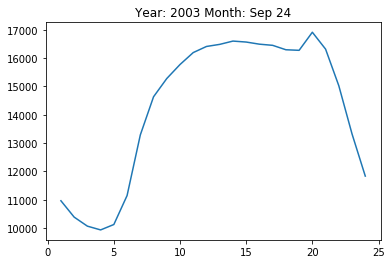

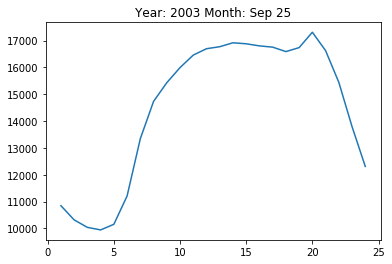

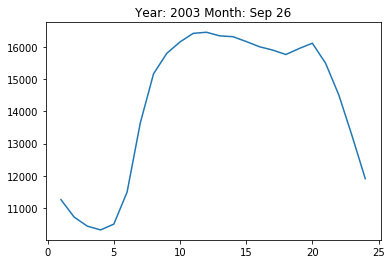

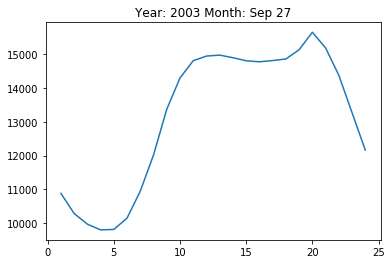

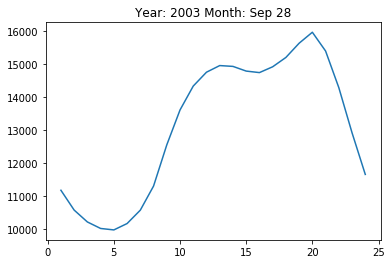

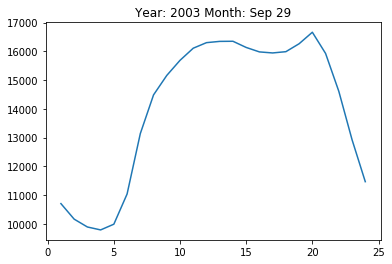

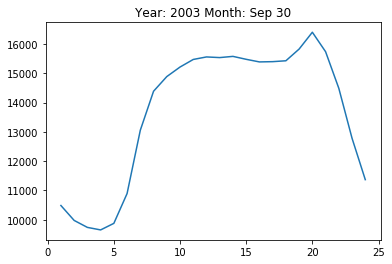

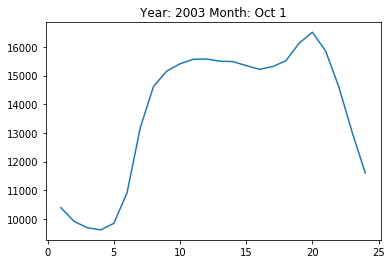

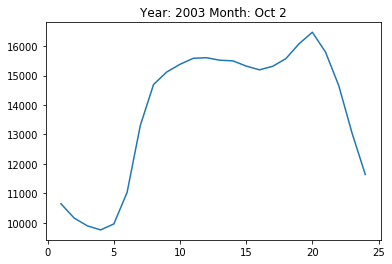

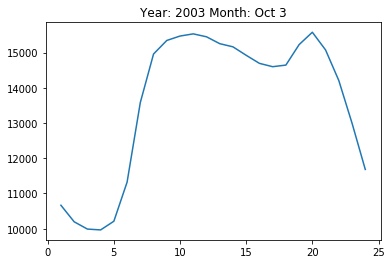

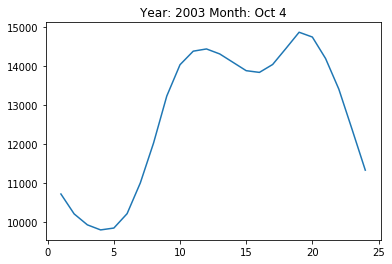

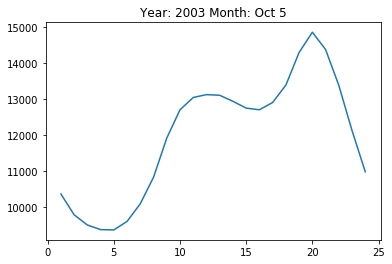

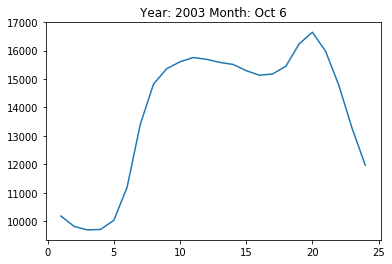

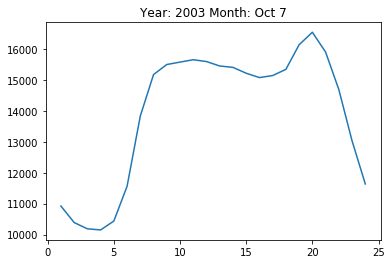

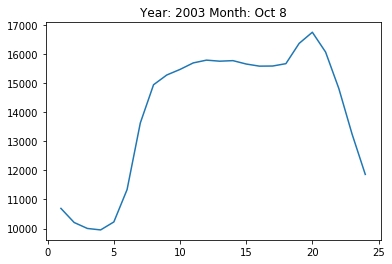

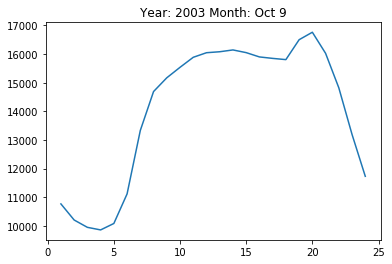

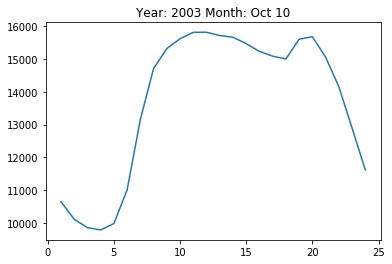

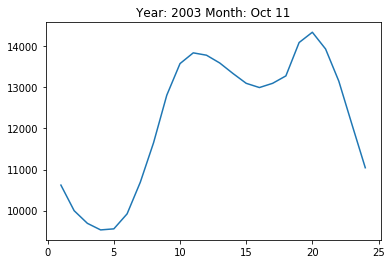

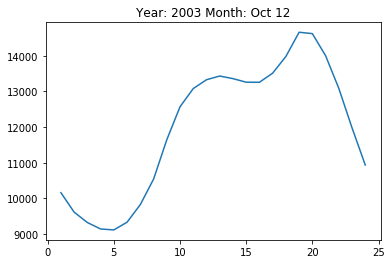

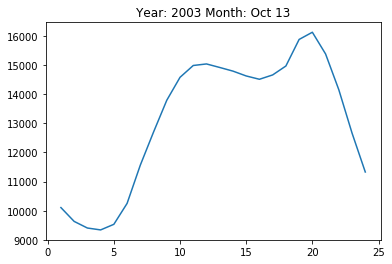

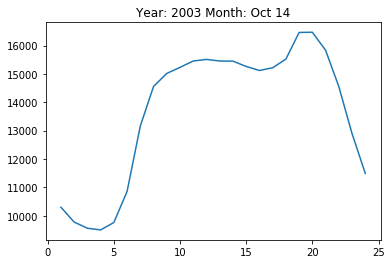

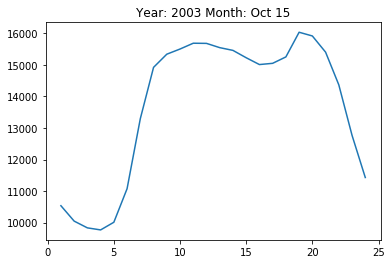

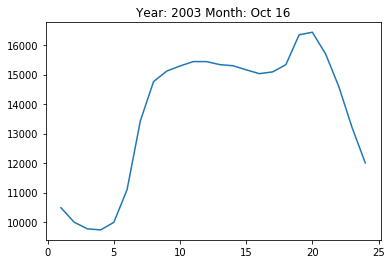

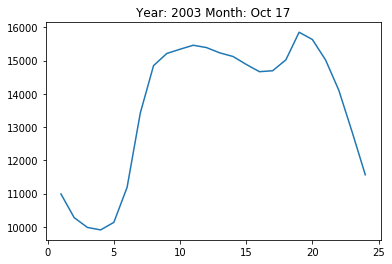

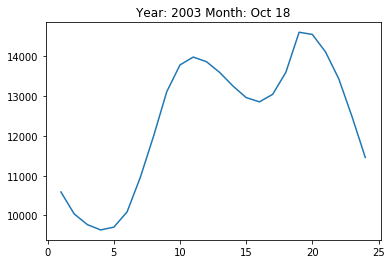

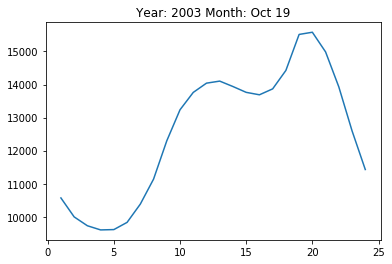

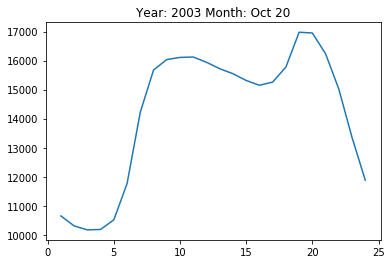

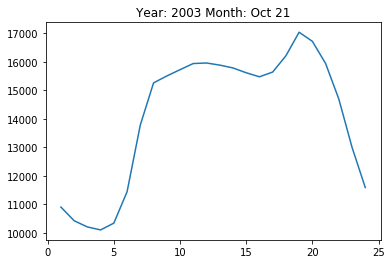

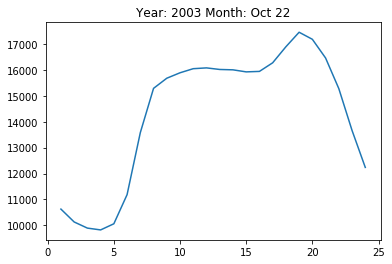

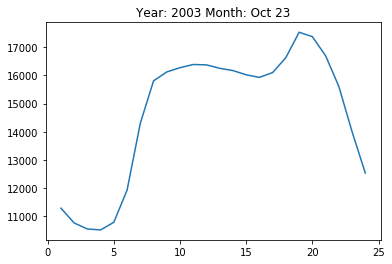

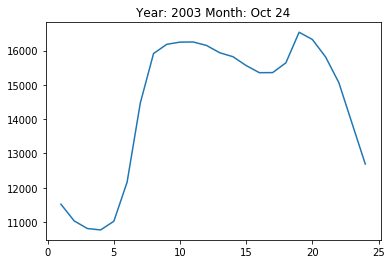

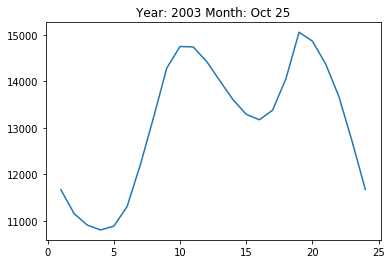

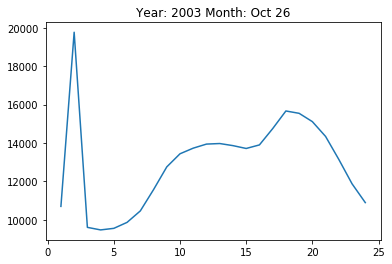

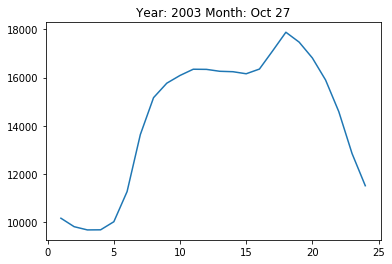

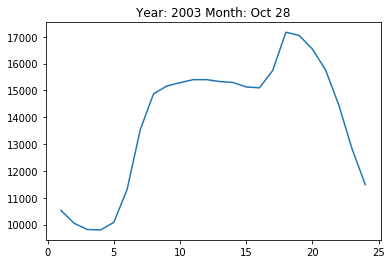

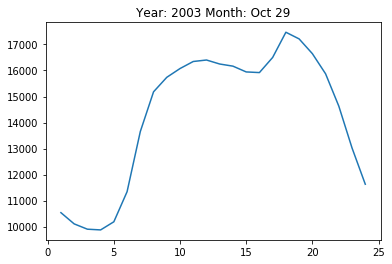

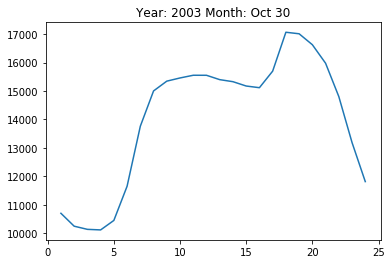

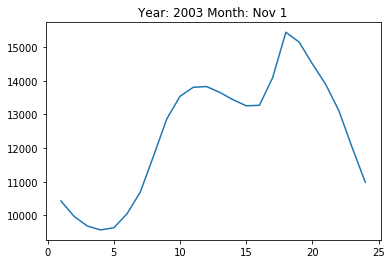

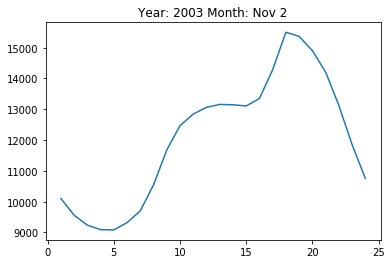

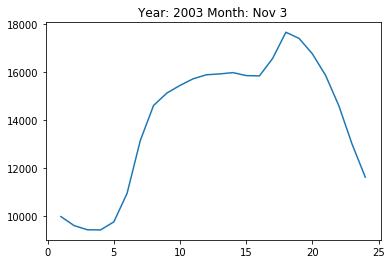

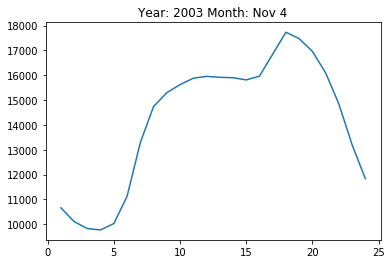

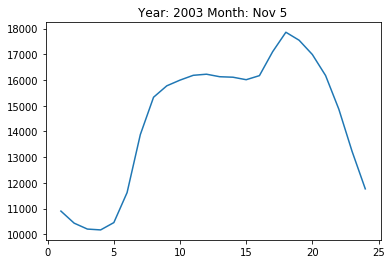

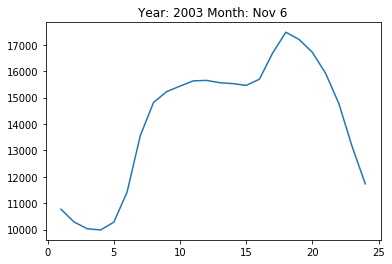

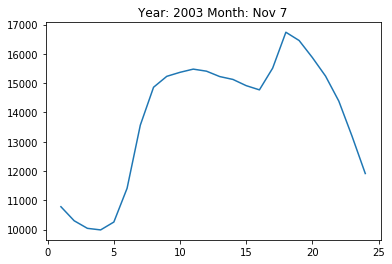

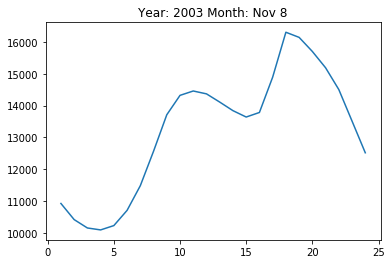

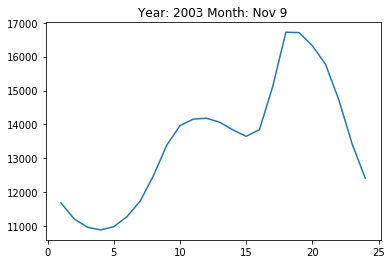

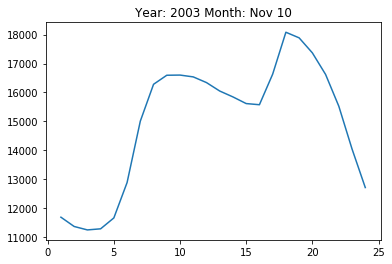

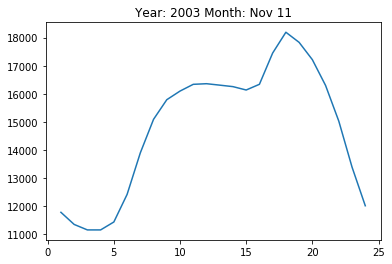

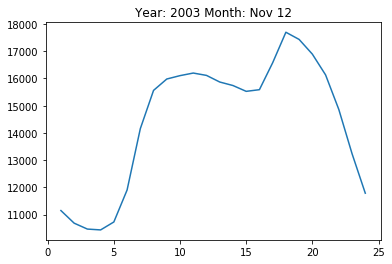

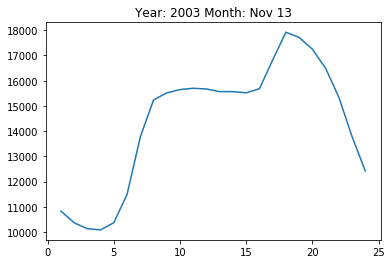

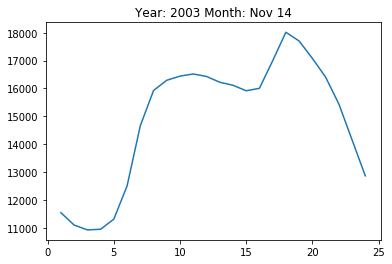

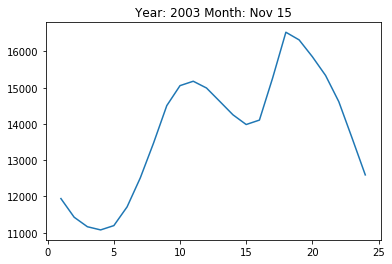

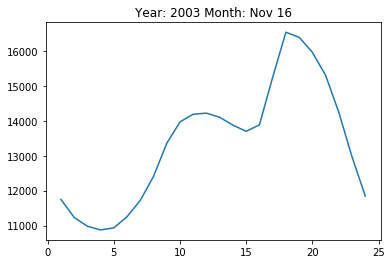

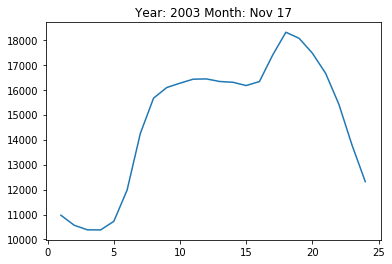

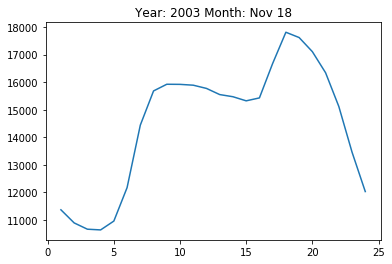

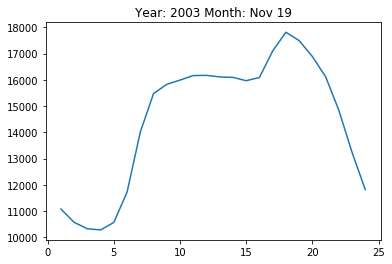

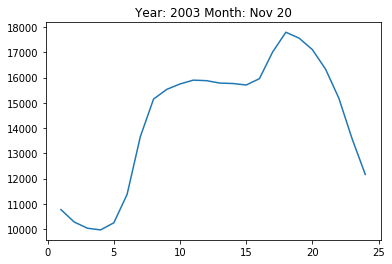

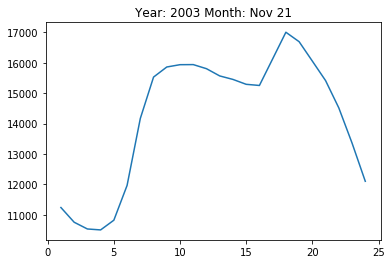

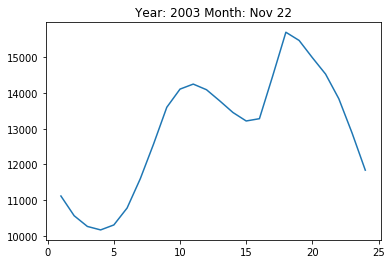

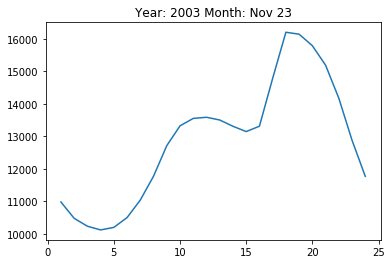

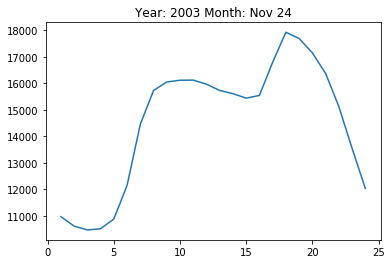

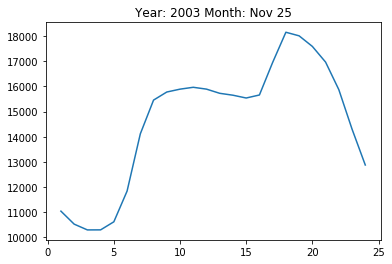

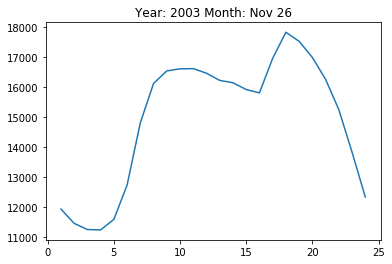

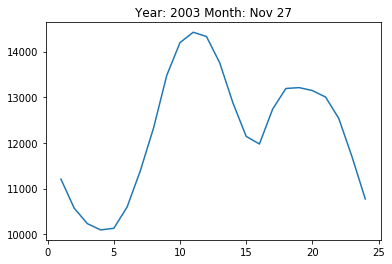

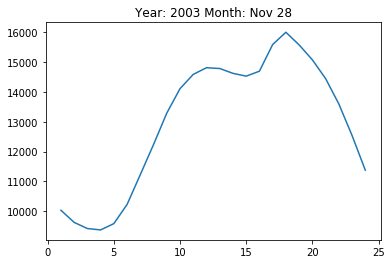

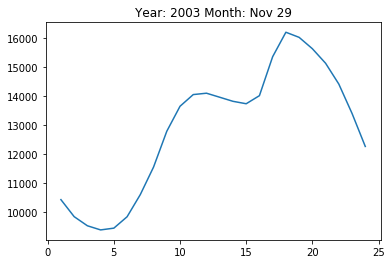

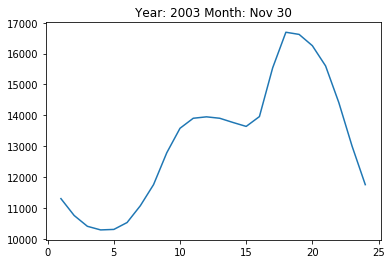

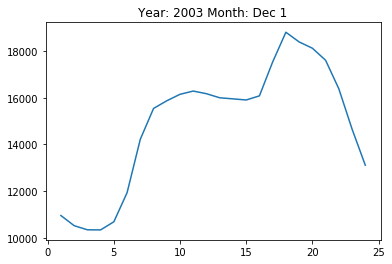

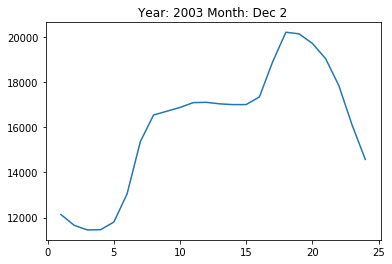

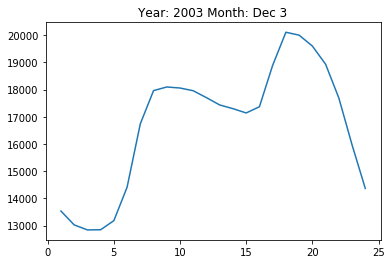

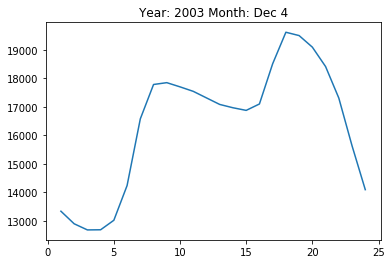

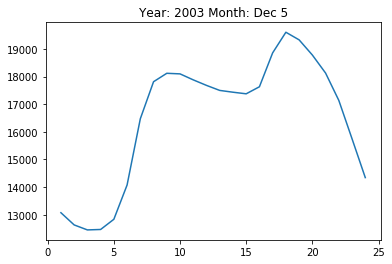

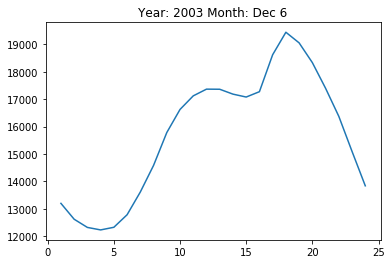

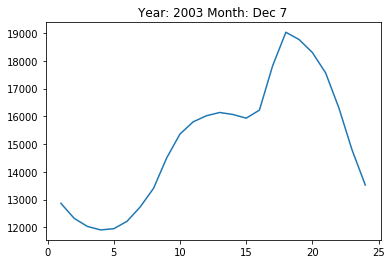

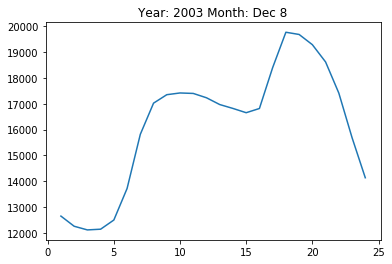

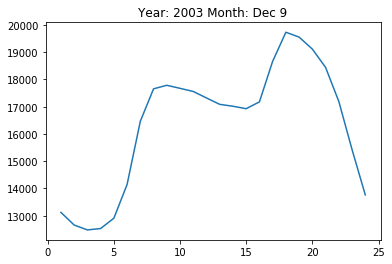

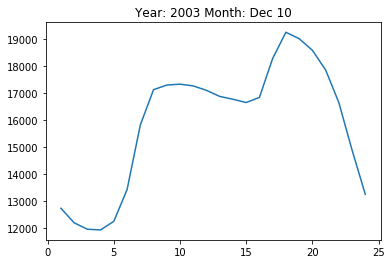

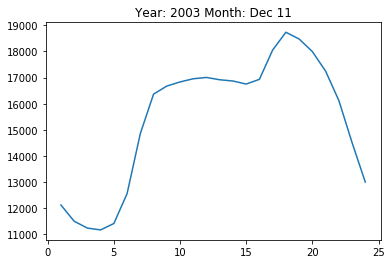

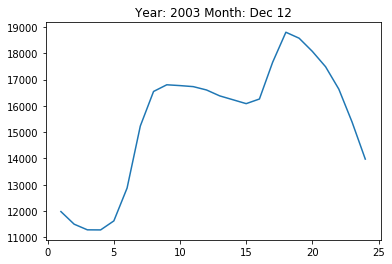

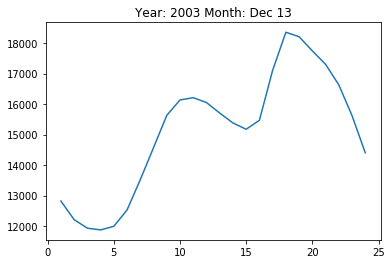

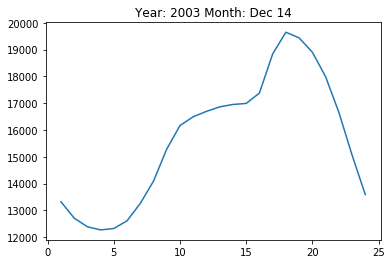

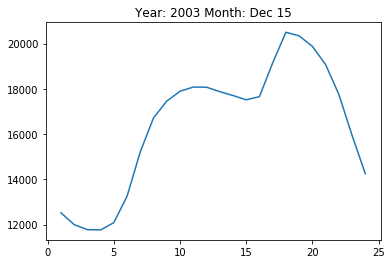

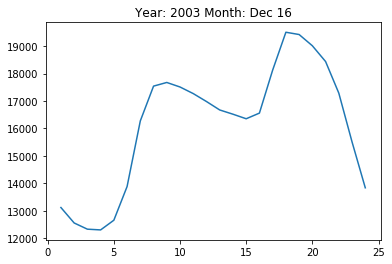

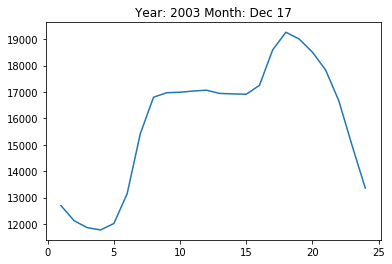

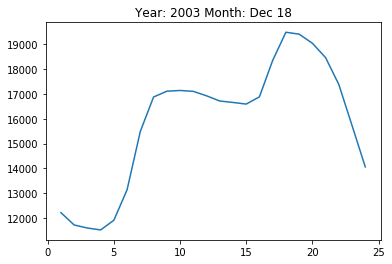

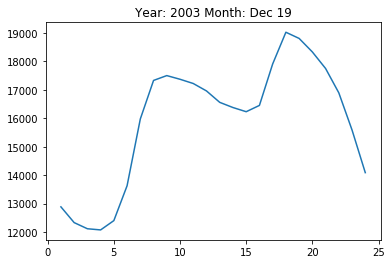

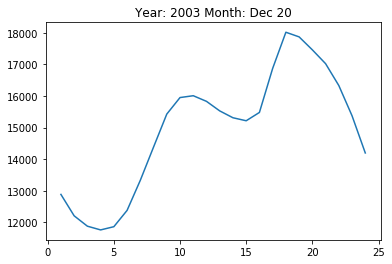

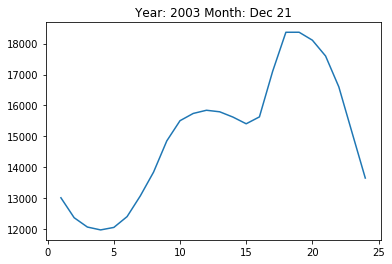

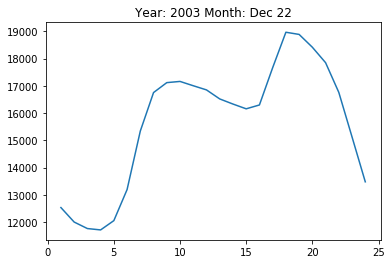

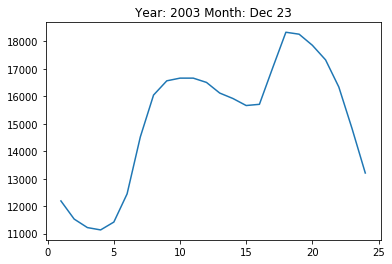

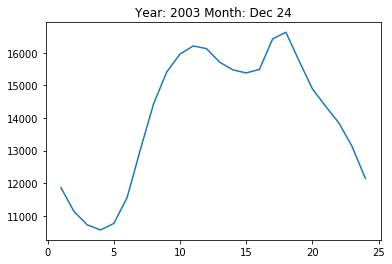

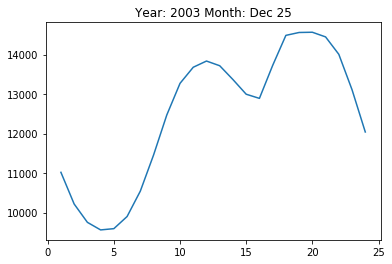

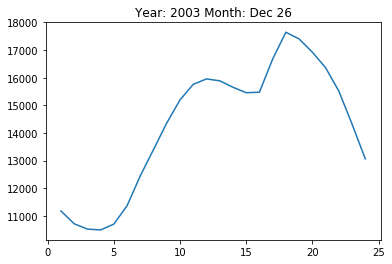

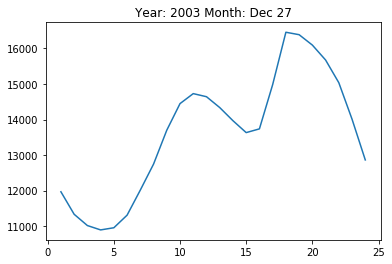

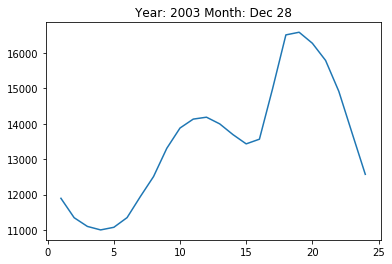

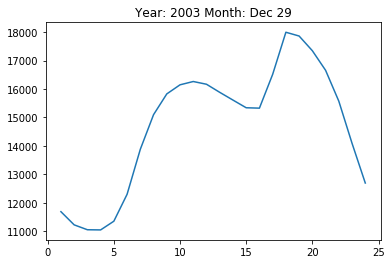

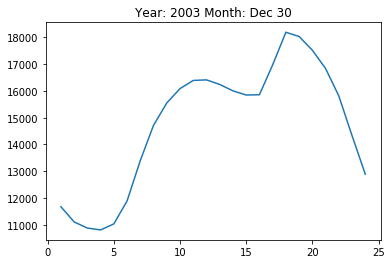

In [64]:
plot_daily_demand(df_master,2003)

In [74]:
### saving model 

from sklearn.externals import joblib

In [92]:
# filename = 'model/lstm_dense.sav'
# joblib.dump(model, filename)

['model/lstm_dense.sav']

In [76]:
def give_daily_demand(df,y):
    '''
    It returns the daily load demand vs hour for a specific year.
    
    df = dataframe
    y = year
    
    '''
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    dfx = df.loc[df.year==y]

    for i,m in enumerate(set(dfx.month)):
        if m in set(dfx.month):
            dfxx = dfx.loc[dfx.month==m]
            #print(monthDict[m],end=' ')
            for d in range(1,31):
                if d in set(dfxx.day):
                    #print(d)
                    dfxxx = dfxx.loc[dfxx.day==d]
                    ttl = str('Year: '+str(y)+' Month: '+str(monthDict[m])+' '+str(d))
                    #plt.figure(ttl)
                    #plt.plot(dfxxx.hour,dfxxx.demand)
                    #print(dfxxx)
                    #plt.title(ttl)
        return dfxxx,ttl

In [77]:
dfxxx,ttl = give_daily_demand(df_master,2004)
print(dfxxx)

            year  month  day  weekday  hour   demand  temperature
date                                                             
2004-01-30  2004      1   30        6     1  14411.0           15
2004-01-30  2004      1   30        6     2  14040.0           14
2004-01-30  2004      1   30        6     3  13864.0           14
2004-01-30  2004      1   30        6     4  13841.0           14
2004-01-30  2004      1   30        6     5  14142.0           13
2004-01-30  2004      1   30        6     6  15301.0           12
2004-01-30  2004      1   30        6     7  17558.0           12
2004-01-30  2004      1   30        6     8  18832.0           12
2004-01-30  2004      1   30        6     9  18946.0           12
2004-01-30  2004      1   30        6    10  18889.0           13
2004-01-30  2004      1   30        6    11  18785.0           16
2004-01-30  2004      1   30        6    12  18521.0           19
2004-01-30  2004      1   30        6    13  18227.0           20
2004-01-30

In [64]:
dfxxx.shape

(24, 7)

In [79]:
test

array([[[ 3.,  2.,  1., 24., 35.,  3.]]])

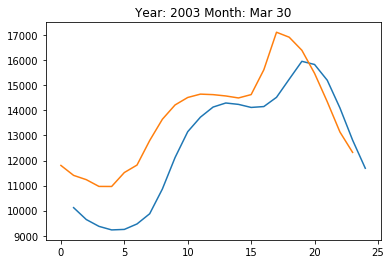

In [61]:
plt.figure(ttl)
plt.plot(dfxxx.hour,dfxxx.demand)
plt.title(ttl)
plt.plot([i for i in range(24)],test_y)

In [62]:
print(dfxxx)

            year  month  day  weekday  hour   demand  temperature
date                                                             
2003-03-30  2003      3   30        1     1  10120.0           52
2003-03-30  2003      3   30        1     2   9646.0           50
2003-03-30  2003      3   30        1     3   9374.0           49
2003-03-30  2003      3   30        1     4   9232.0           48
2003-03-30  2003      3   30        1     5   9252.0           47
2003-03-30  2003      3   30        1     6   9470.0           45
2003-03-30  2003      3   30        1     7   9877.0           45
2003-03-30  2003      3   30        1     8  10863.0           44
2003-03-30  2003      3   30        1     9  12117.0           43
2003-03-30  2003      3   30        1    10  13149.0           43
2003-03-30  2003      3   30        1    11  13728.0           42
2003-03-30  2003      3   30        1    12  14131.0           42
2003-03-30  2003      3   30        1    13  14293.0           41
2003-03-30

In [65]:
test_y

[11803.389507353306,
 11406.688725113869,
 11236.080577135086,
 10966.345184981823,
 10964.226268827915,
 11520.073788940907,
 11818.145362854004,
 12796.326458990574,
 13644.595933139324,
 14215.075828790665,
 14513.176214694977,
 14646.844097137451,
 14626.456732153893,
 14573.618833065033,
 14493.938036561012,
 14627.798547744751,
 15617.054150104523,
 17114.362295150757,
 16916.428854703903,
 16394.951570510864,
 15475.518124461174,
 14345.411398649216,
 13137.485954165459,
 12323.422075986862]

In [85]:
test_y = []
true_y = []
for i in range(48,24*3):
    test = X[i]
    true_y.append(Y[i]*D_max)
    test = test.reshape(1,1,6)
    y = model.predict(test)
    test_y.append(y[0][0]*D_max)

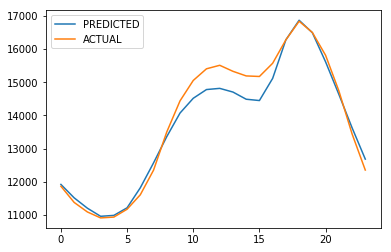

In [90]:
plt.plot(test_y)
plt.plot(true_y)
plt.legend(['PREDICTED','ACTUAL'])

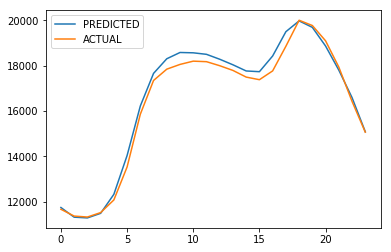

In [91]:
test_y = []
true_y = []
for i in range(48,24*3):
    test = X[i]
    true_y.append(Y[i]*D_max)
    test = test.reshape(1,1,6)
    y = model.predict(test)
    test_y.append(y[0][0]*D_max)


    
plt.plot(test_y)
plt.plot(true_y)
plt.legend(['PREDICTED','ACTUAL'])